In [1]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from dsa_analysis import load_config, visualize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
import main
from main import RNNLayer
import ast
import DSA
import copy
from notebooks.utils_rnn import *
%load_ext autoreload
%autoreload 2


### Load config

In [2]:
config = load_config("../config.yaml")
taskset = "PDM"

In [3]:
# Define font sizes and styles for consistency
SIZE_DEFAULT = 18
SIZE_LARGE = 20
plt.rc("font", family="Arial")
plt.rc("font", weight="normal")
plt.rc("font", size=SIZE_DEFAULT)
plt.rc("axes", titlesize=SIZE_LARGE)
plt.rc("axes", labelsize=SIZE_LARGE)
plt.rc("xtick", labelsize=SIZE_DEFAULT)
plt.rc("ytick", labelsize=SIZE_DEFAULT)
name_measures_plot = {"cka": "CKA", "procrustes": "Procrustes", "dsa": "DSA"}

### Get dissimilarities

#### Computation dynamics

In [4]:
path = f"../data/dissimilarities/{taskset}/"
df = get_dataframe(path, taskset)
df_selected, models_trained_per_group = select_df(df)



In [5]:
group_pairs = find_group_pairs(config, taskset)
dissimilarities_per_shared_task = dissimilarities_per_percentage_of_shared_task(group_pairs, df_selected)

#### Learning dynamics

For now, only analysis for pretrain_frozen against pretrain_unfrozen

In [6]:
dissimilarities_groups, groups_training = get_dissimilarities_groups(taskset, models_trained_per_group)

/Users/qguilhot/Library/Mobile Documents/com~apple~CloudDocs/ETHZ/RepAL/notebooks/utils_rnn.py:595: RuntimeWarning: Mean of empty slice
  np.nanmean(dissimilarities_interpolated[measure][group]),
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/repal-8PB6Q6y1-py3.11/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


dsa
5
5
beta: -0.004760506172004576
intercept: 0.587019763233619
r2 score: 0.5186461879082722
p value beta = 1.150771962841374e-23


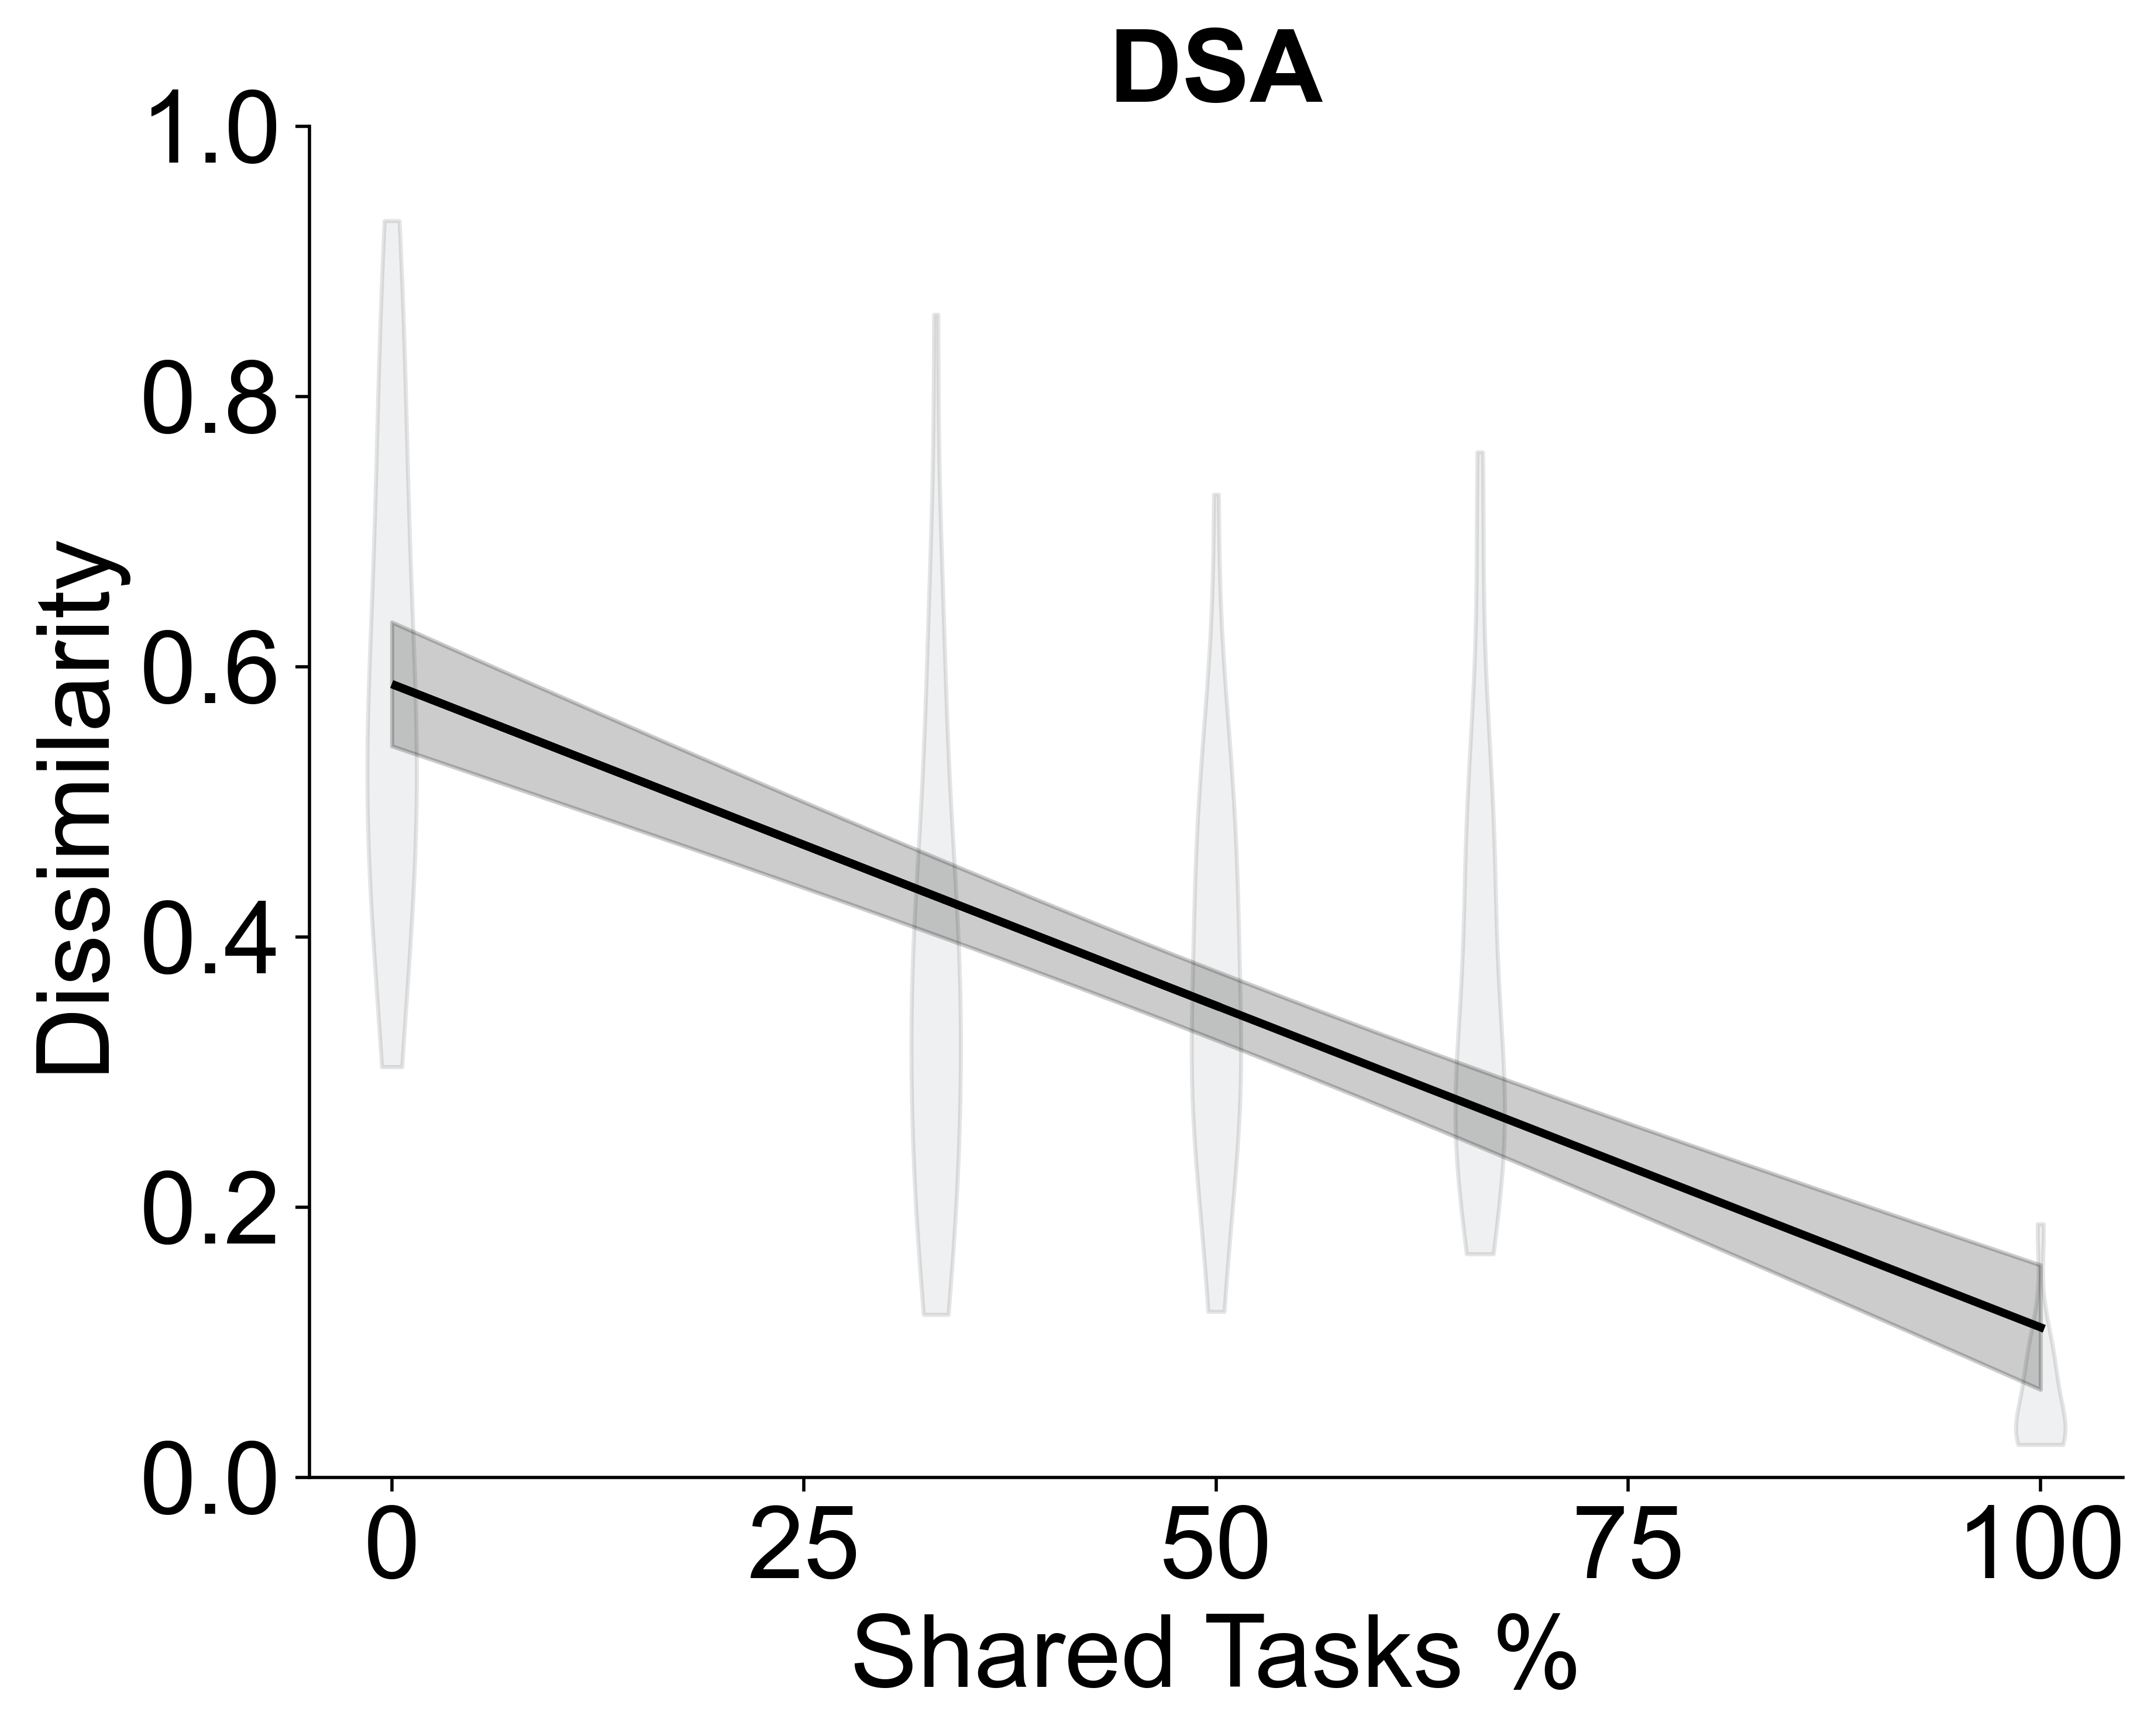

cka
5
5
beta: -0.0034505798905765076
intercept: 0.48178170963533995
r2 score: 0.3018126403215107
p value beta = 2.0821228133824232e-12


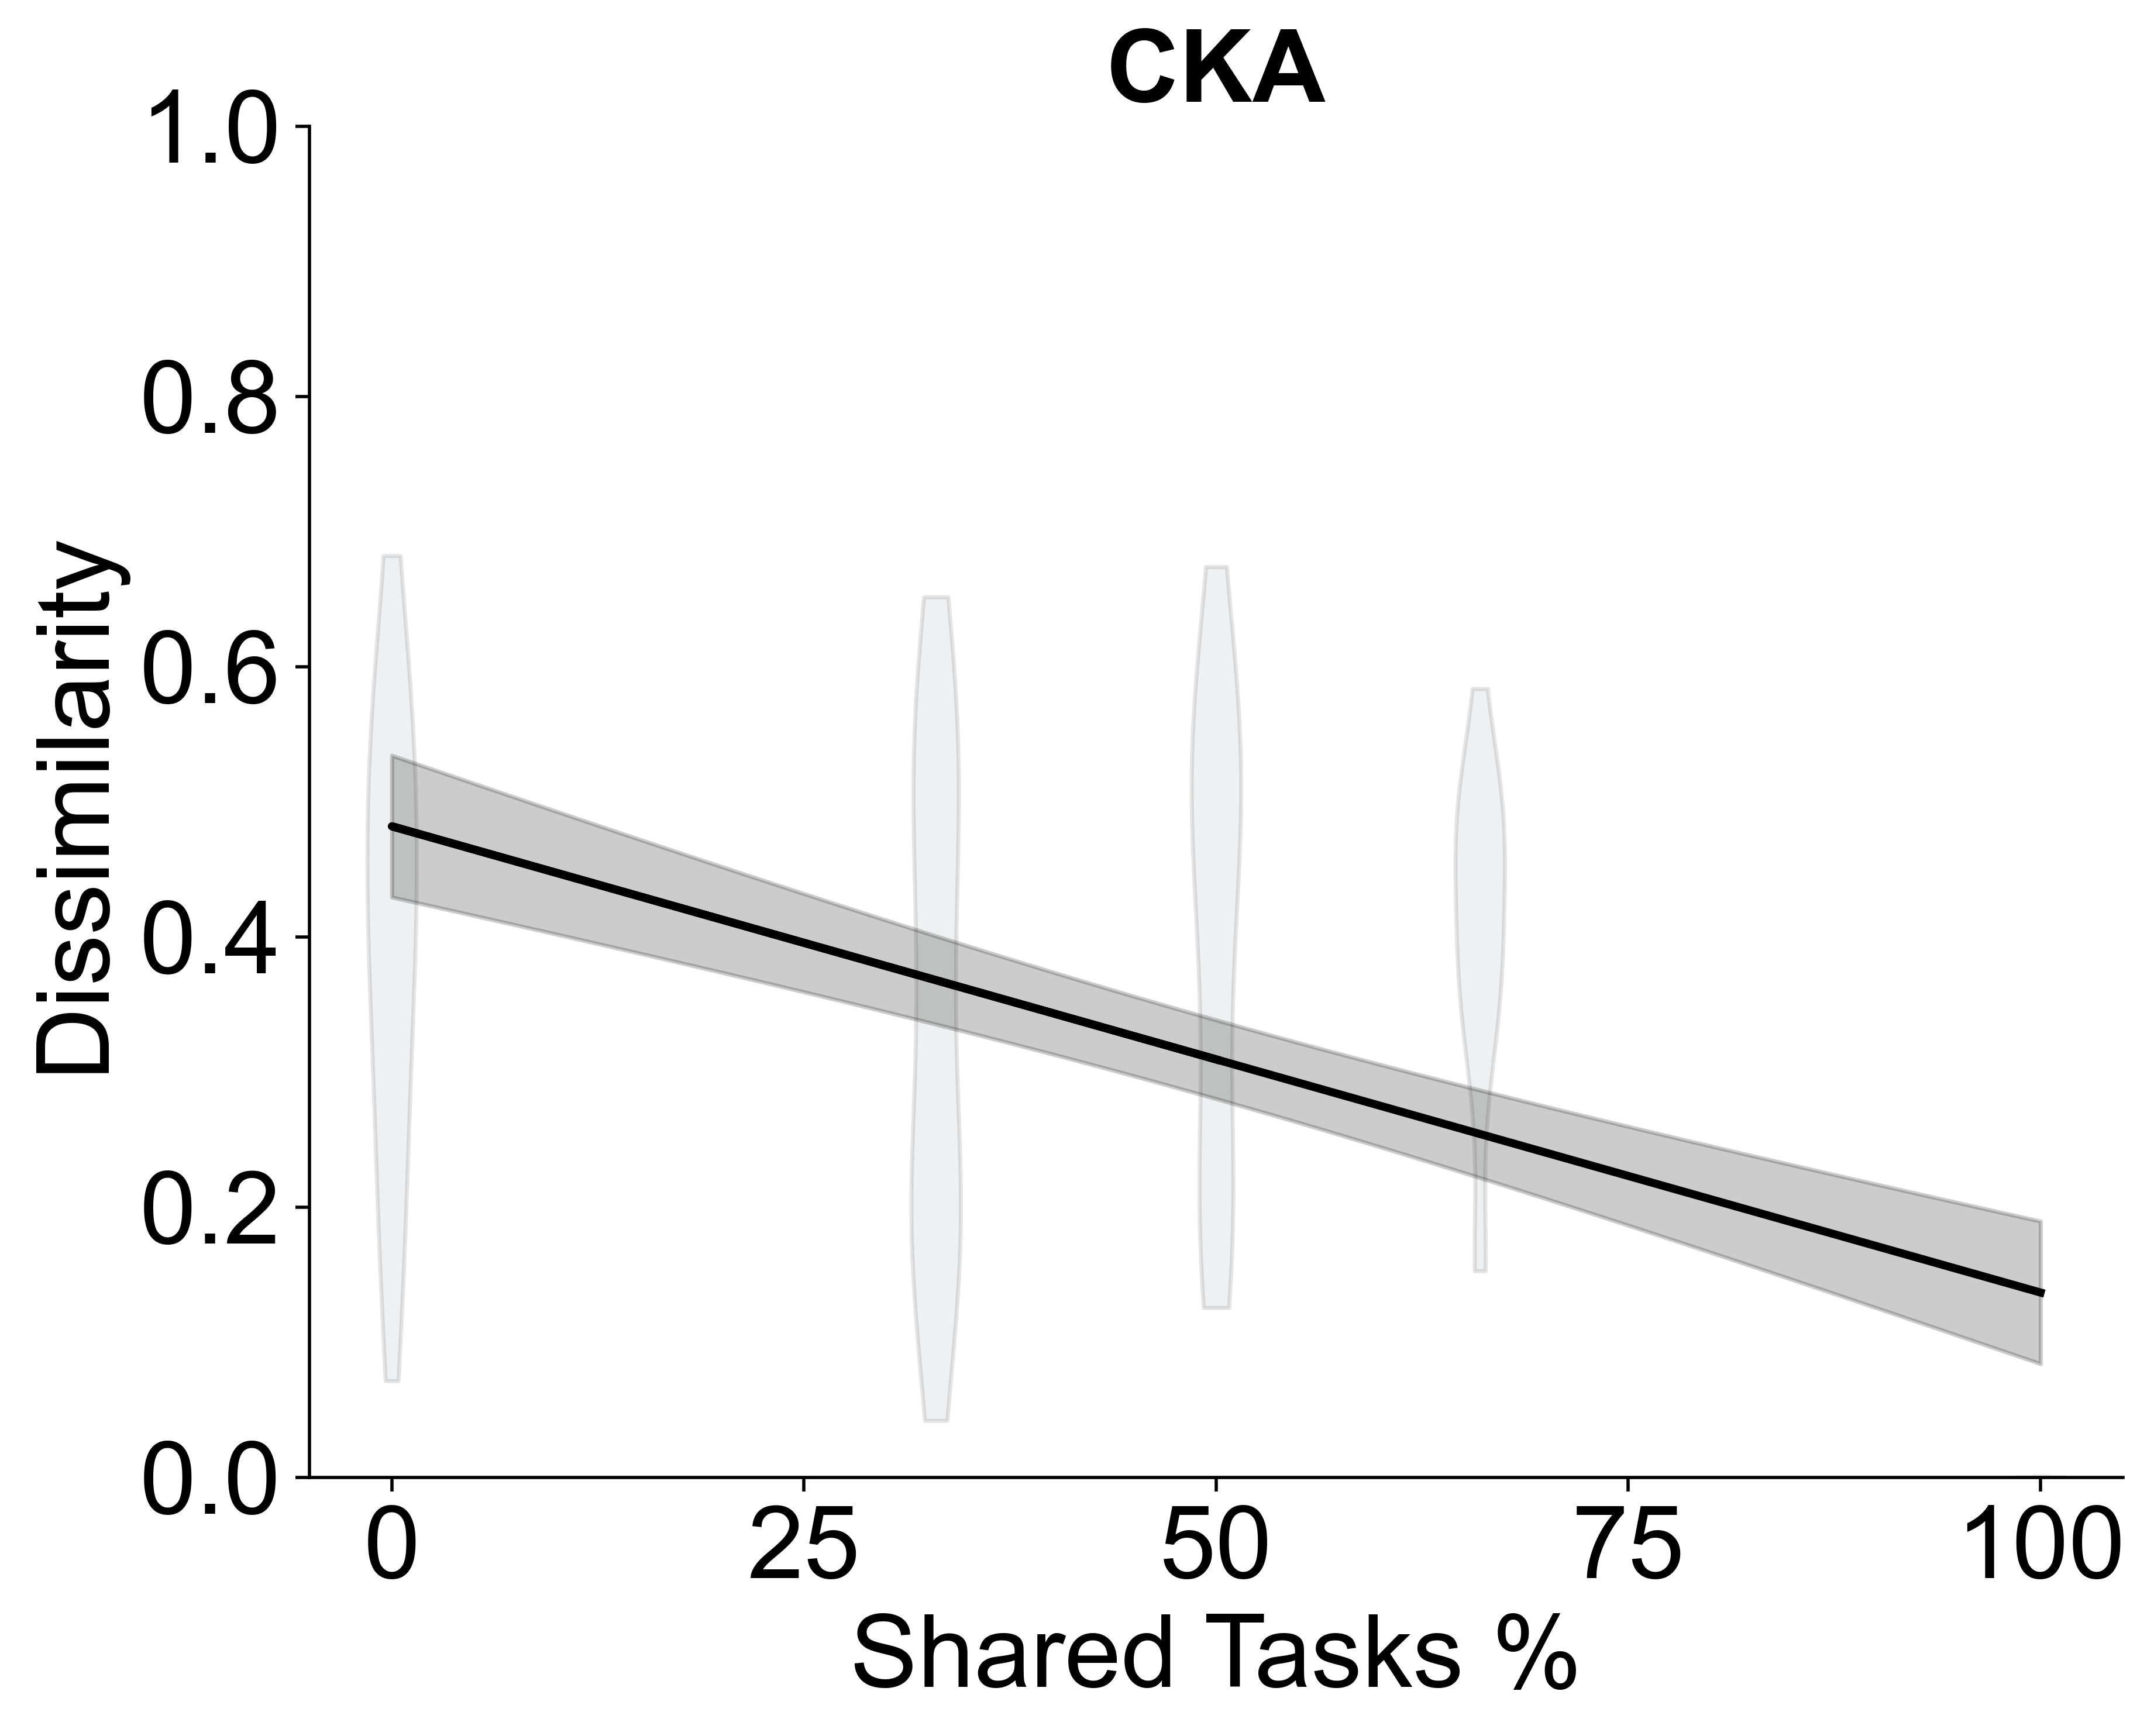

procrustes
5
5
beta: -0.0035303728704106506
intercept: 0.4939905490379257
r2 score: 0.3985887331373221
p value beta = 6.154975029070447e-17


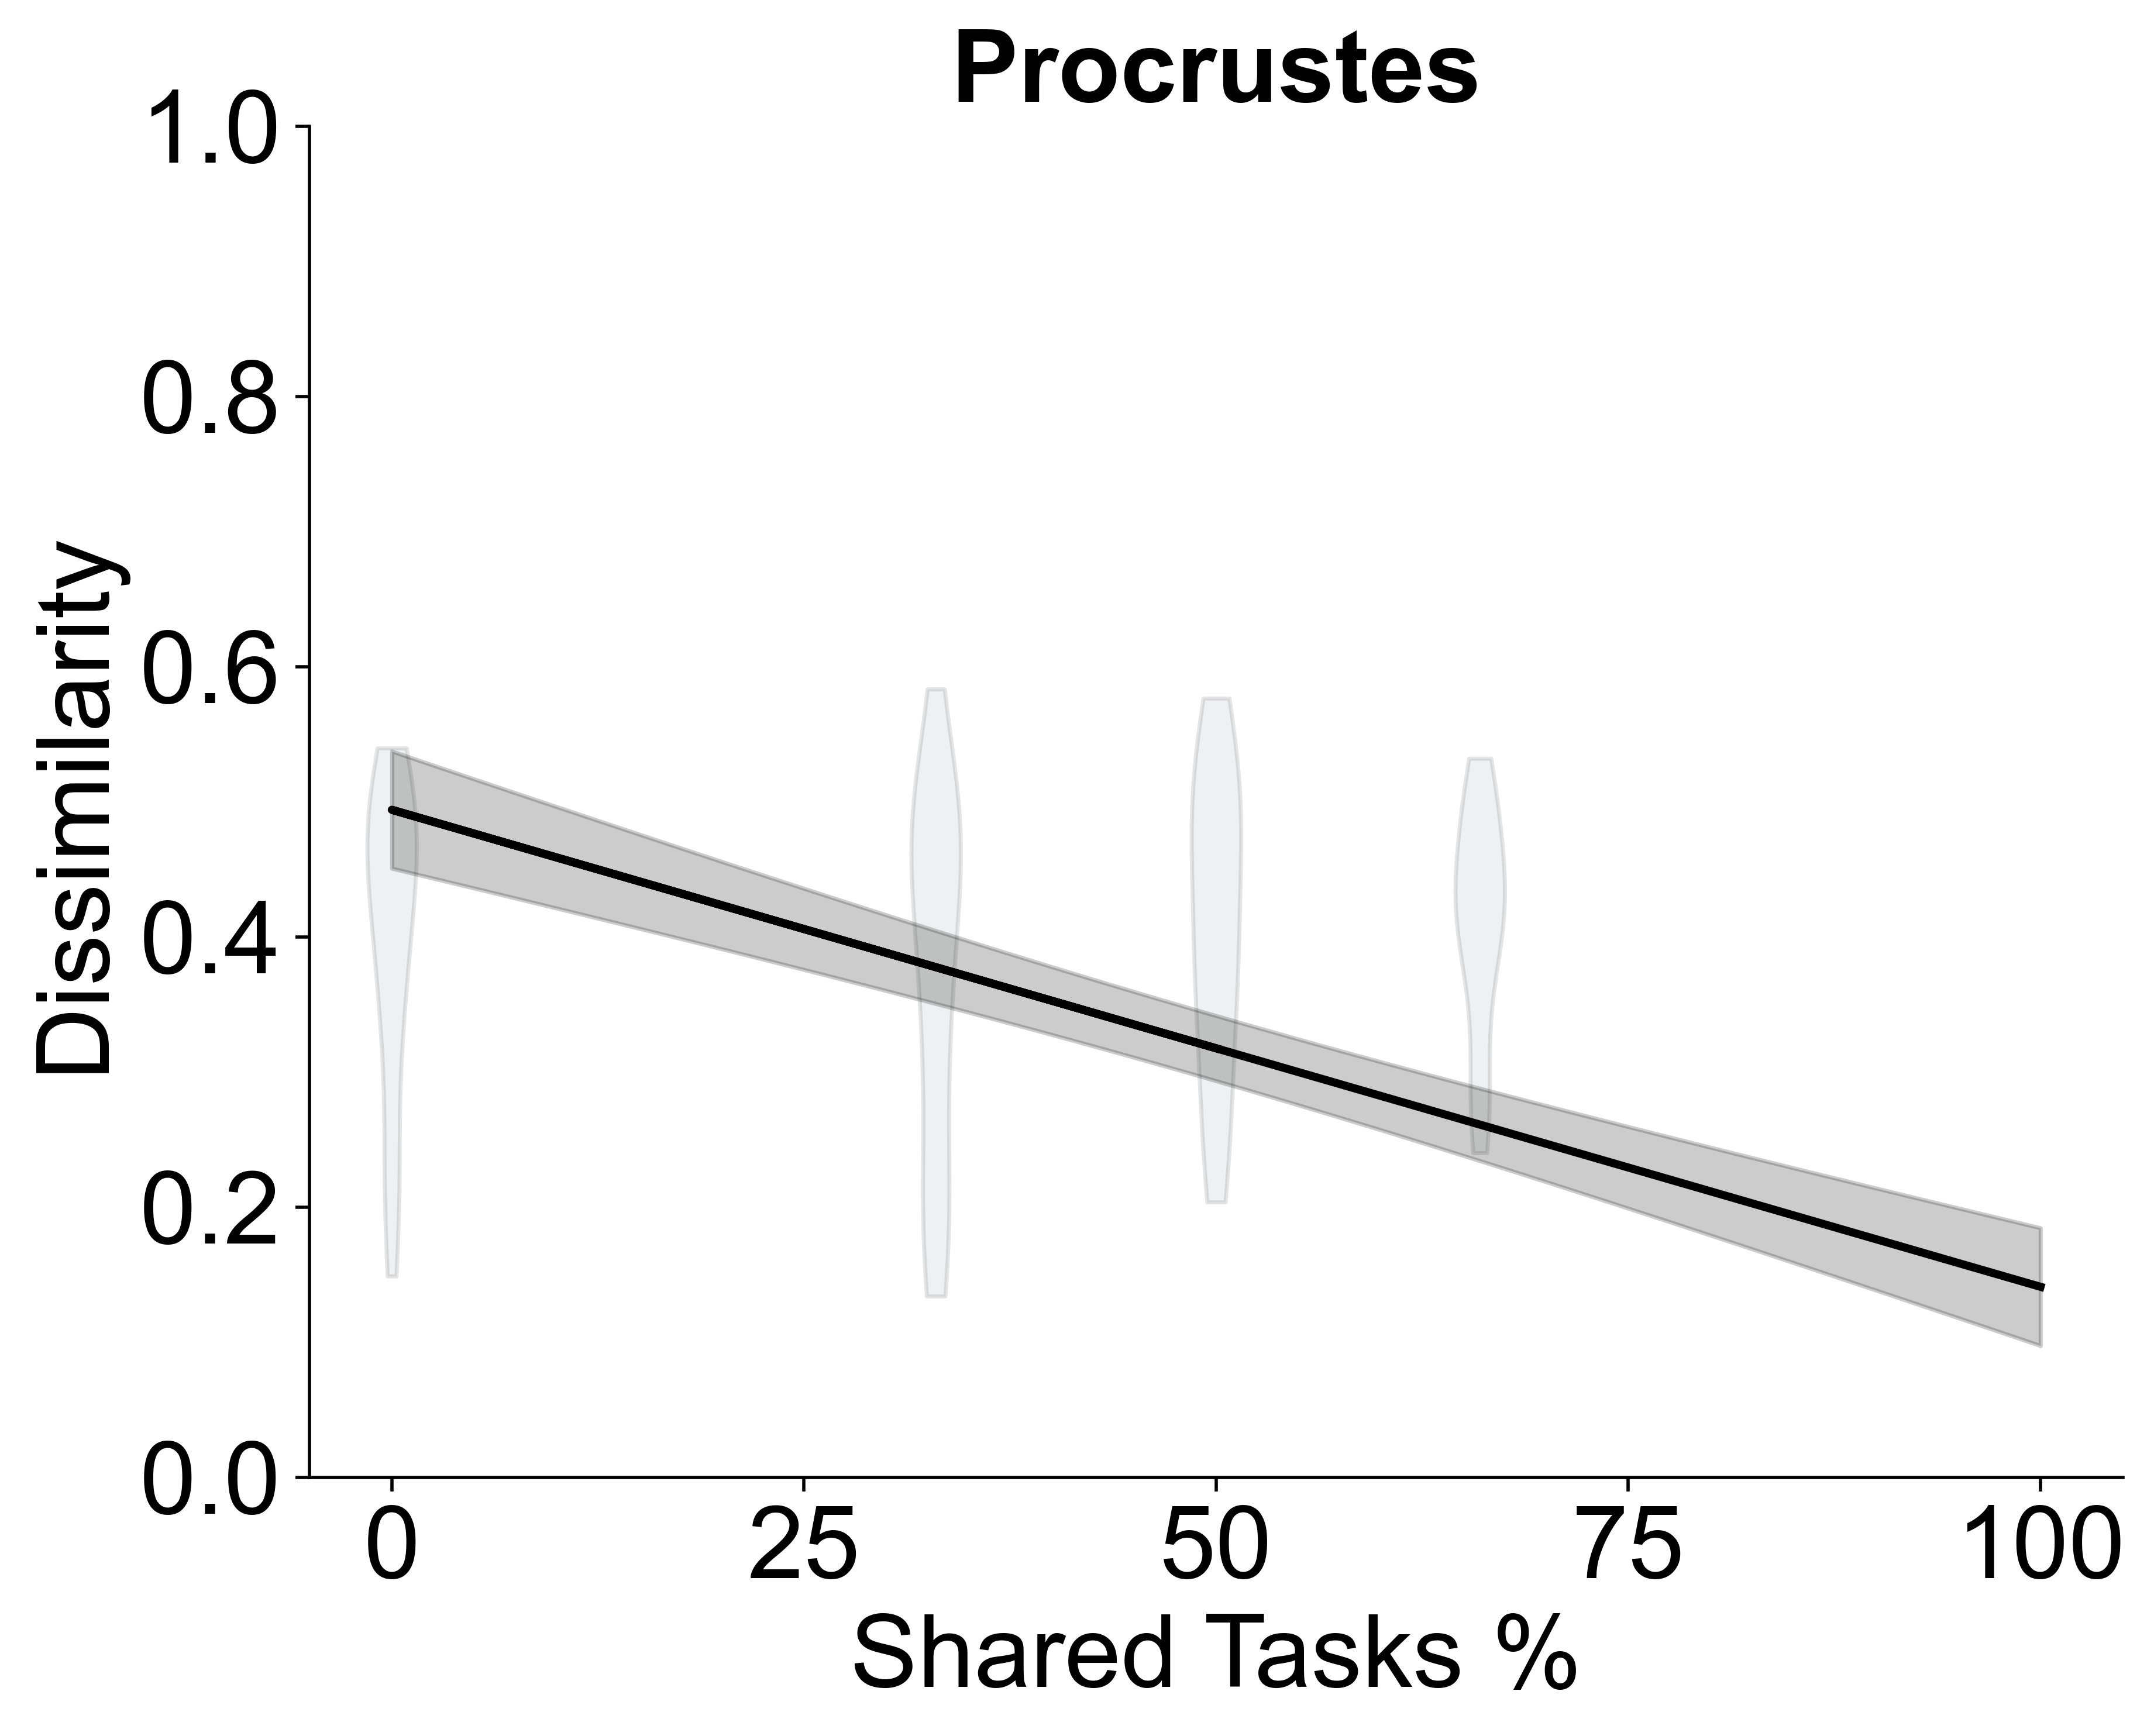

In [7]:
from turtle import color
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats

# Define font sizes and styles for consistency
SIZE_DEFAULT = 25
SIZE_LARGE = 25
plt.rc("font", family="Arial")
plt.rc("font", weight="normal")
plt.rc("font", size=SIZE_DEFAULT)
plt.rc("axes", titlesize=SIZE_LARGE)
plt.rc("axes", labelsize=SIZE_LARGE)
plt.rc("xtick", labelsize=SIZE_DEFAULT)
plt.rc("ytick", labelsize=SIZE_DEFAULT)
name_measures_plot = {"cka": "CKA", "procrustes": "Procrustes", "dsa": "DSA"}

# Iterate over each measure to compute linear regression and uncertainty
for measure in dissimilarities_per_shared_task:
    X = []  # Store shared_tasks as X
    y = []  # Store dissimilarities as y
    print(measure)

    # Aggregate all (shared_task, dissimilarity) pairs across all models
    observations = []
    positions = []
    for shared_tasks, models_data in dissimilarities_per_shared_task[measure].items():
        dissimilarities = []
        for model, dissimilarity_list in models_data.items():
            dissimilarity = dissimilarity_list[0]  # Extract single dissimilarity value
            X.append(shared_tasks)
            y.append(dissimilarity)
            dissimilarities.append(dissimilarity)
        observations.append(dissimilarities)
        positions.append(shared_tasks)
    print(len(positions))
    print(len(observations))

    # Convert to numpy arrays for linear regression
    X = np.array(X).reshape(-1, 1)  # Reshape to a 2D array
    y = np.array(y)

    # Perform linear regression
    model = LinearRegression()
    model.fit(X, y)

    # Get the slope (beta) and intercept
    beta = model.coef_[0]
    intercept = model.intercept_

    print(f"beta: {beta}")
    print(f"intercept: {intercept}")
    print(f"r2 score: {model.score(X, y)}")

    # Predict y values for the regression line
    y_pred = model.predict(X)

    # Compute residuals and their variance
    residuals = y - y_pred
    residual_variance = np.var(residuals, ddof=2)

    # Compute variance of X
    X_mean = np.mean(X)
    X_variance = np.sum((X - X_mean) ** 2)

    # Standard error of the slope (beta)
    standard_error_beta = np.sqrt(residual_variance / X_variance)

    # T-statistic and p-value
    t_statistic = beta / standard_error_beta
    df = len(X) - 2  # degrees of freedom
    p_value = 2 * stats.t.sf(np.abs(t_statistic), df)

    print(f"p value beta = {p_value}")

    # Mis-specification error (MSE)
    mse = np.mean(residuals**2)

    # Confidence interval for the regression line
    X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_pred_range = model.predict(X_range)
    se_line = np.sqrt(
        residual_variance * (1 / len(X) + (X_range - X_mean) ** 2 / X_variance)
    )
    ci_upper = y_pred_range.flatten() + 1.96 * se_line.flatten()
    ci_lower = y_pred_range.flatten() - 1.96 * se_line.flatten()

    # Create the main plot and space for two boxes below
    fig, ax_main = plt.subplots(figsize=(8, 6), dpi=500)

    # Main plot: scatter plot of observations and the regression line
    parts = ax_main.violinplot(
        observations,
        positions,
        showmeans=False,
        showmedians=False,
        showextrema=False,
        widths=3,
    )
    for pc in parts["bodies"]:
        pc.set_facecolor("#696D7D")
        pc.set_edgecolor("black")
        pc.set_alpha(0.1)
    ax_main.plot(
        X,
        y_pred,
        "-",
        color="black",
        linewidth=2,
    )
    ax_main.fill_between(
        X_range.flatten(),
        ci_lower,
        ci_upper,
        color="black",
        alpha=0.2,
    )

    # Set axis labels and title for the main plot
    ax_main.set_title(f"{name_measures_plot[measure]}", color="black", fontweight="bold")
    ax_main.set_xlabel("Shared Tasks %")
    ax_main.set_ylabel(f"Dissimilarity")
    ax_main.set_xlim(-5,105)
    ax_main.set_ylim(0, 1)
    # Customize axis limits and hide the top and right spines
    ax_main.spines["right"].set_visible(False)
    ax_main.spines["top"].set_visible(False)
    ax_main.spines["left"].set_visible(True)  # Show the left y-axis
    ax_main.yaxis.set_ticks_position("left")
    ax_main.xaxis.set_ticks_position("bottom")


    # Remove legend if it has no labels
    if ax_main.get_legend_handles_labels() != ([], []):
        ax_main.legend()
    ax_main.grid(False)
    plt.show()

['pretrain_frozen_', '']
cka
procrustes
dsa


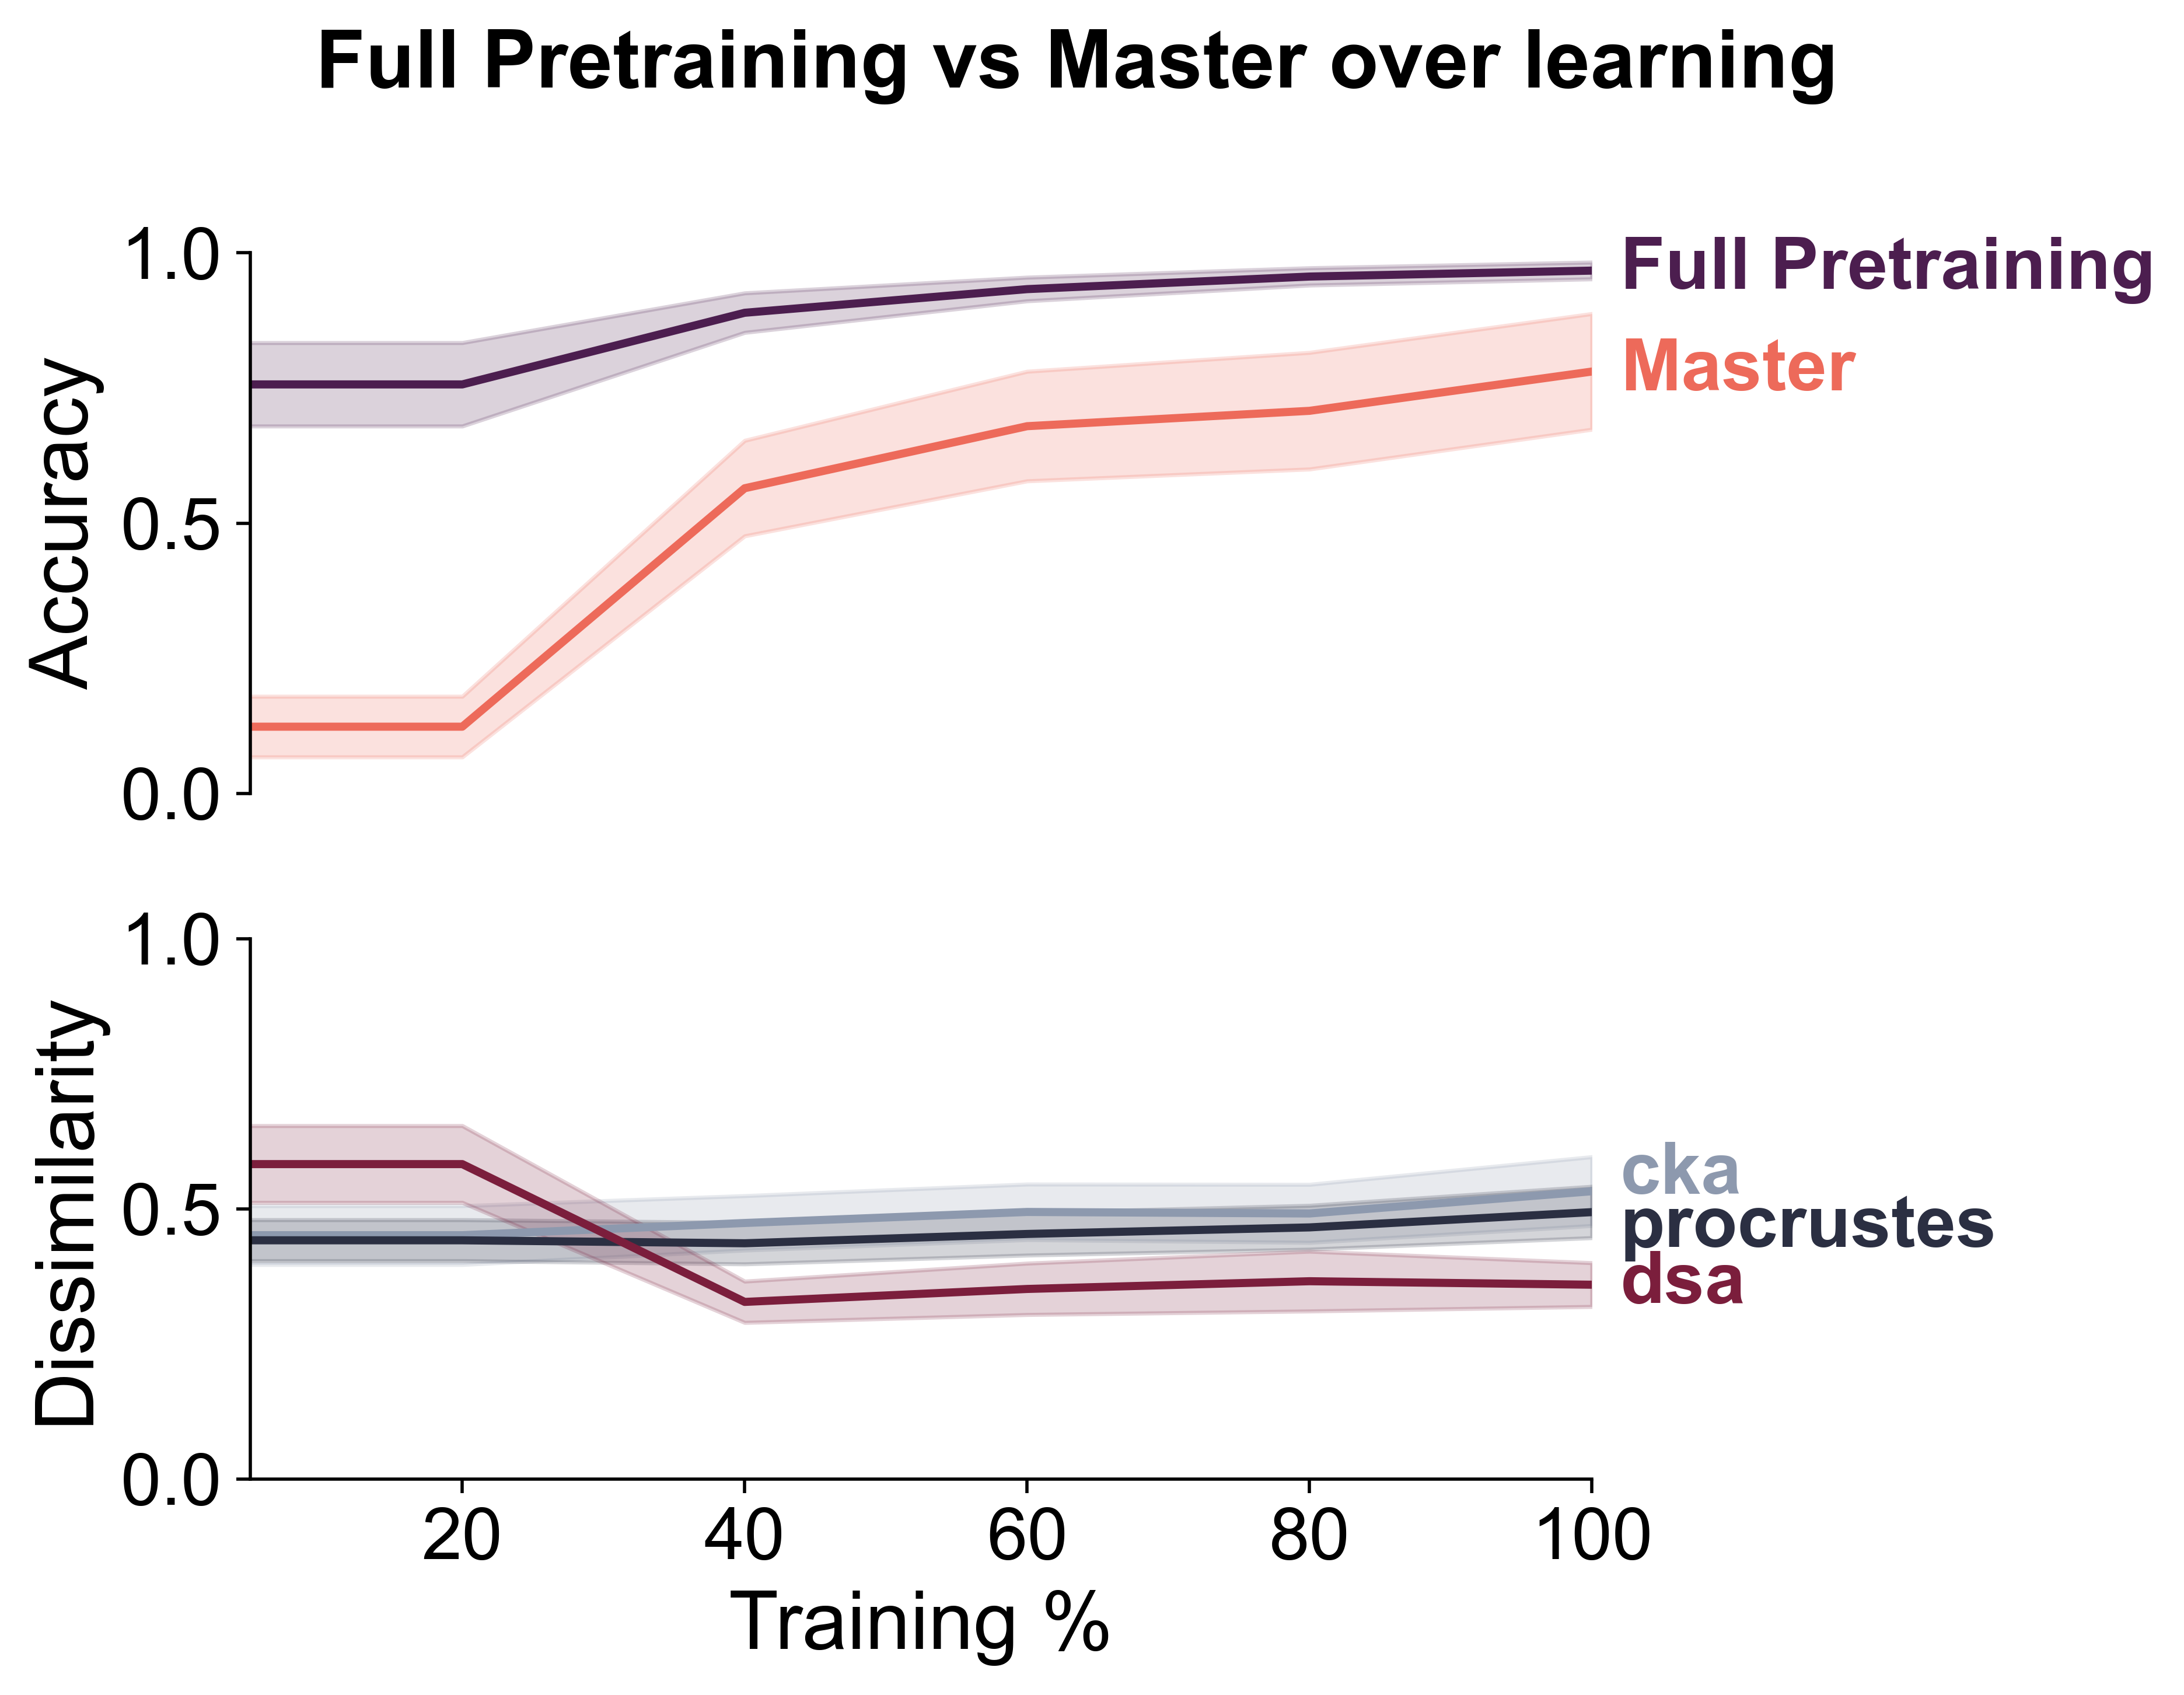

In [8]:
import os
from turtle import color
import numpy as np
import matplotlib.pyplot as plt

# Assuming dissimilarities_groups is defined from your previous code
SIZE_DEFAULT = 18
SIZE_LARGE = 20
plt.rc("font", family="Arial")
plt.rc("font", weight="normal")
plt.rc("font", size=SIZE_DEFAULT)
plt.rc("axes", titlesize=SIZE_LARGE)
plt.rc("axes", labelsize=SIZE_LARGE)
plt.rc("xtick", labelsize=SIZE_DEFAULT)
plt.rc("ytick", labelsize=SIZE_DEFAULT)

# Iterate over each group in groups_training
for group_training in groups_training:
    if group_training == "pretrain_frozen_master":
        groups = group_training.split("master")
        if groups[0] == "":
            group1 = "master"
            group2 = groups[1][1:]
        else:
            group1 = groups[0][:-1]
            group2 = "master"
        print(groups)
        dissimilarities_interpolated = dissimilarities_groups[group_training]

        # X-axis values
        x_values = [i * 20 for i in range(6)]

        # Measures for the two plots
        measures_plot1 = ["cka", "procrustes", "dsa"]
        measures_plot2 = ["accuracy_1", "accuracy_2"]

        # Create the figure and the two subplots
        fig, axs = plt.subplots(
            2, 1, figsize=(8, 6), sharex=True, dpi=500
        )  # 2 rows, 1 column

        # Add a global title for the figure
        fig.suptitle(
            f"{group_mapping_names[group1]} vs {group_mapping_names[group2]} over learning",
            fontsize=SIZE_LARGE,
            fontweight="bold",
        )

        # Plot for the first set of measures (dissimilarities)
        shifts = [0.03, -0.03, 0]  # Shift the labels slightly to avoid overlap
        for i, key in enumerate(measures_plot1):
            print(key)
            dictionary_measures = dissimilarities_interpolated[key]
            means = [value[0] for value in dictionary_measures.values()]
            errors = [value[1] for value in dictionary_measures.values()]

            # Plot with shaded area for standard error
            axs[1].plot(
                x_values,
                means,
                label=key,
                color=color_mapping_metrics[key],
                linewidth=2,
            )
            axs[1].fill_between(
                x_values,
                [m - e for m, e in zip(means, errors)],
                [m + e for m, e in zip(means, errors)],
                color=color_mapping_metrics[key],
                alpha=0.2,
            )

            # Annotate each curve with its label slightly to the right of the last point
            axs[1].text(
                x_values[-1] * 1.02,  # Adjust x position slightly to the right
                means[-1] + shifts[i],
                key,
                color=color_mapping_metrics[key],
                fontweight="bold",
                verticalalignment="center",
            )

        axs[1].set_ylabel("Dissimilarity")
        axs[1].set_ylim(0, 1)
        axs[1].grid(False)
        axs[1].set_xlabel("Training %")  # Keep x-axis label and graduation for axs[1]
        axs[1].set_xlim(5,100)

        # Plot for the second set of measures (accuracy)

        for i, key in enumerate(measures_plot2):
            dictionary_measures = dissimilarities_interpolated[key]
            means = [value[0] for value in dictionary_measures.values()]
            errors = [value[1] for value in dictionary_measures.values()]

            # Rename legend label for accuracy
            label = (
                f"{group_mapping_names[group1]}"
                if i == 0
                else f"{group_mapping_names[group2]}"
            )
            color = color_mapping[group1] if i == 0 else color_mapping[group2]

            # Plot with shaded area for standard error
            axs[0].plot(x_values, means, label=label, color=color, linewidth=2)
            axs[0].fill_between(
                x_values,
                [m - e for m, e in zip(means, errors)],
                [m + e for m, e in zip(means, errors)],
                color=color,
                alpha=0.2,
            )

            # Annotate each curve with its label slightly to the right of the last point
            axs[0].text(
                x_values[-1] * 1.02,  # Adjust x position slightly to the right
                means[-1],  # Adjust y position slightly to avoid overlap
                label,
                color=color,
                fontweight="bold",
                fontsize=SIZE_DEFAULT,
                verticalalignment="center",
            )

        axs[0].set_ylabel("Accuracy")
        axs[0].set_ylim(0, 1)
        axs[0].grid(False)

        # Remove x-axis ticks and labels for the first subplot (axs[0])
        axs[0].tick_params(
            axis="x", which="both", bottom=False, top=False, labelbottom=False
        )

        # Customize plot limits and remove right/top spines
        for ax in axs:
            ax.spines["right"].set_visible(False)
            ax.spines["top"].set_visible(False)
            ax.spines["left"].set_visible(True)
            ax.spines["bottom"].set_visible(True)
            if ax == axs[0]:
                ax.spines["bottom"].set_visible(False)

        # Adjust layout to avoid overlapping elements
        plt.tight_layout()

        # Display the plots
        plt.show()

cka
beta: -0.07520083865923761
intercept: 0.4855258851654943
r squared: 0.012953287260860535
p_value for -0.07520083865923761: 1.2190929640967375e-05


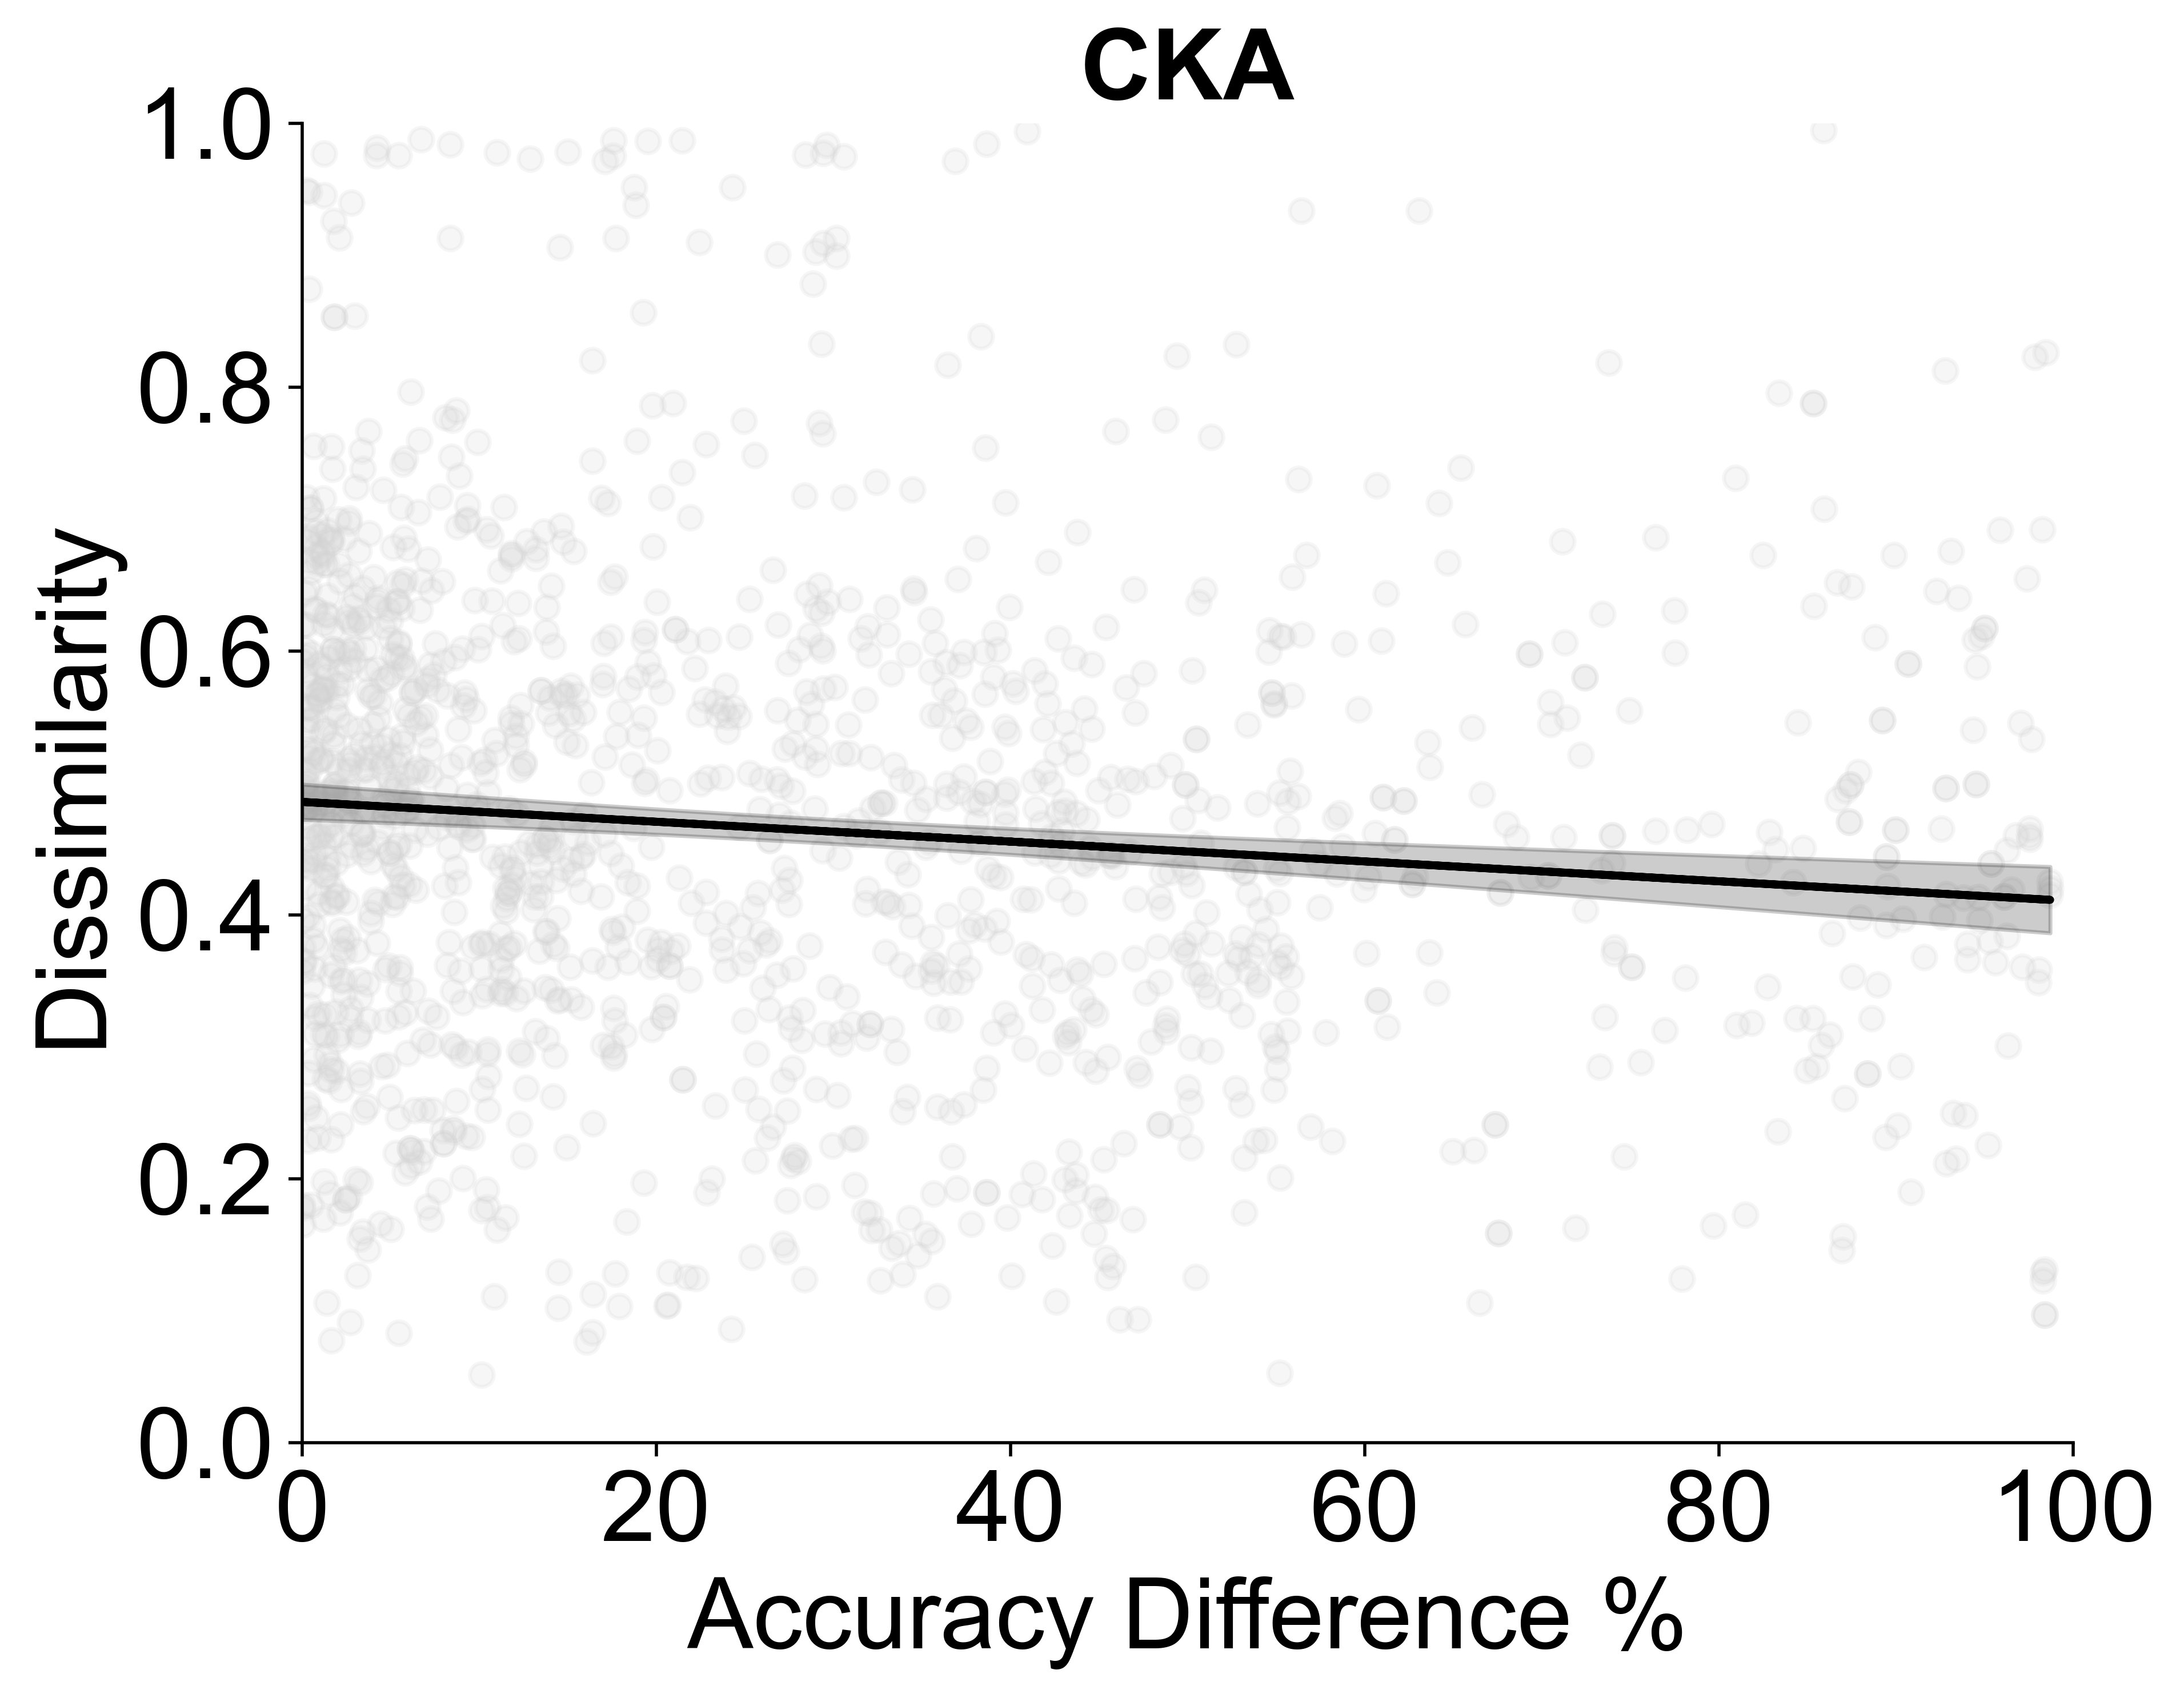

procrustes
beta: -0.05323170766940285
intercept: 0.4406616742853809
r squared: 0.012487509262291807
p_value for -0.05323170766940285: 1.7526413930384043e-05


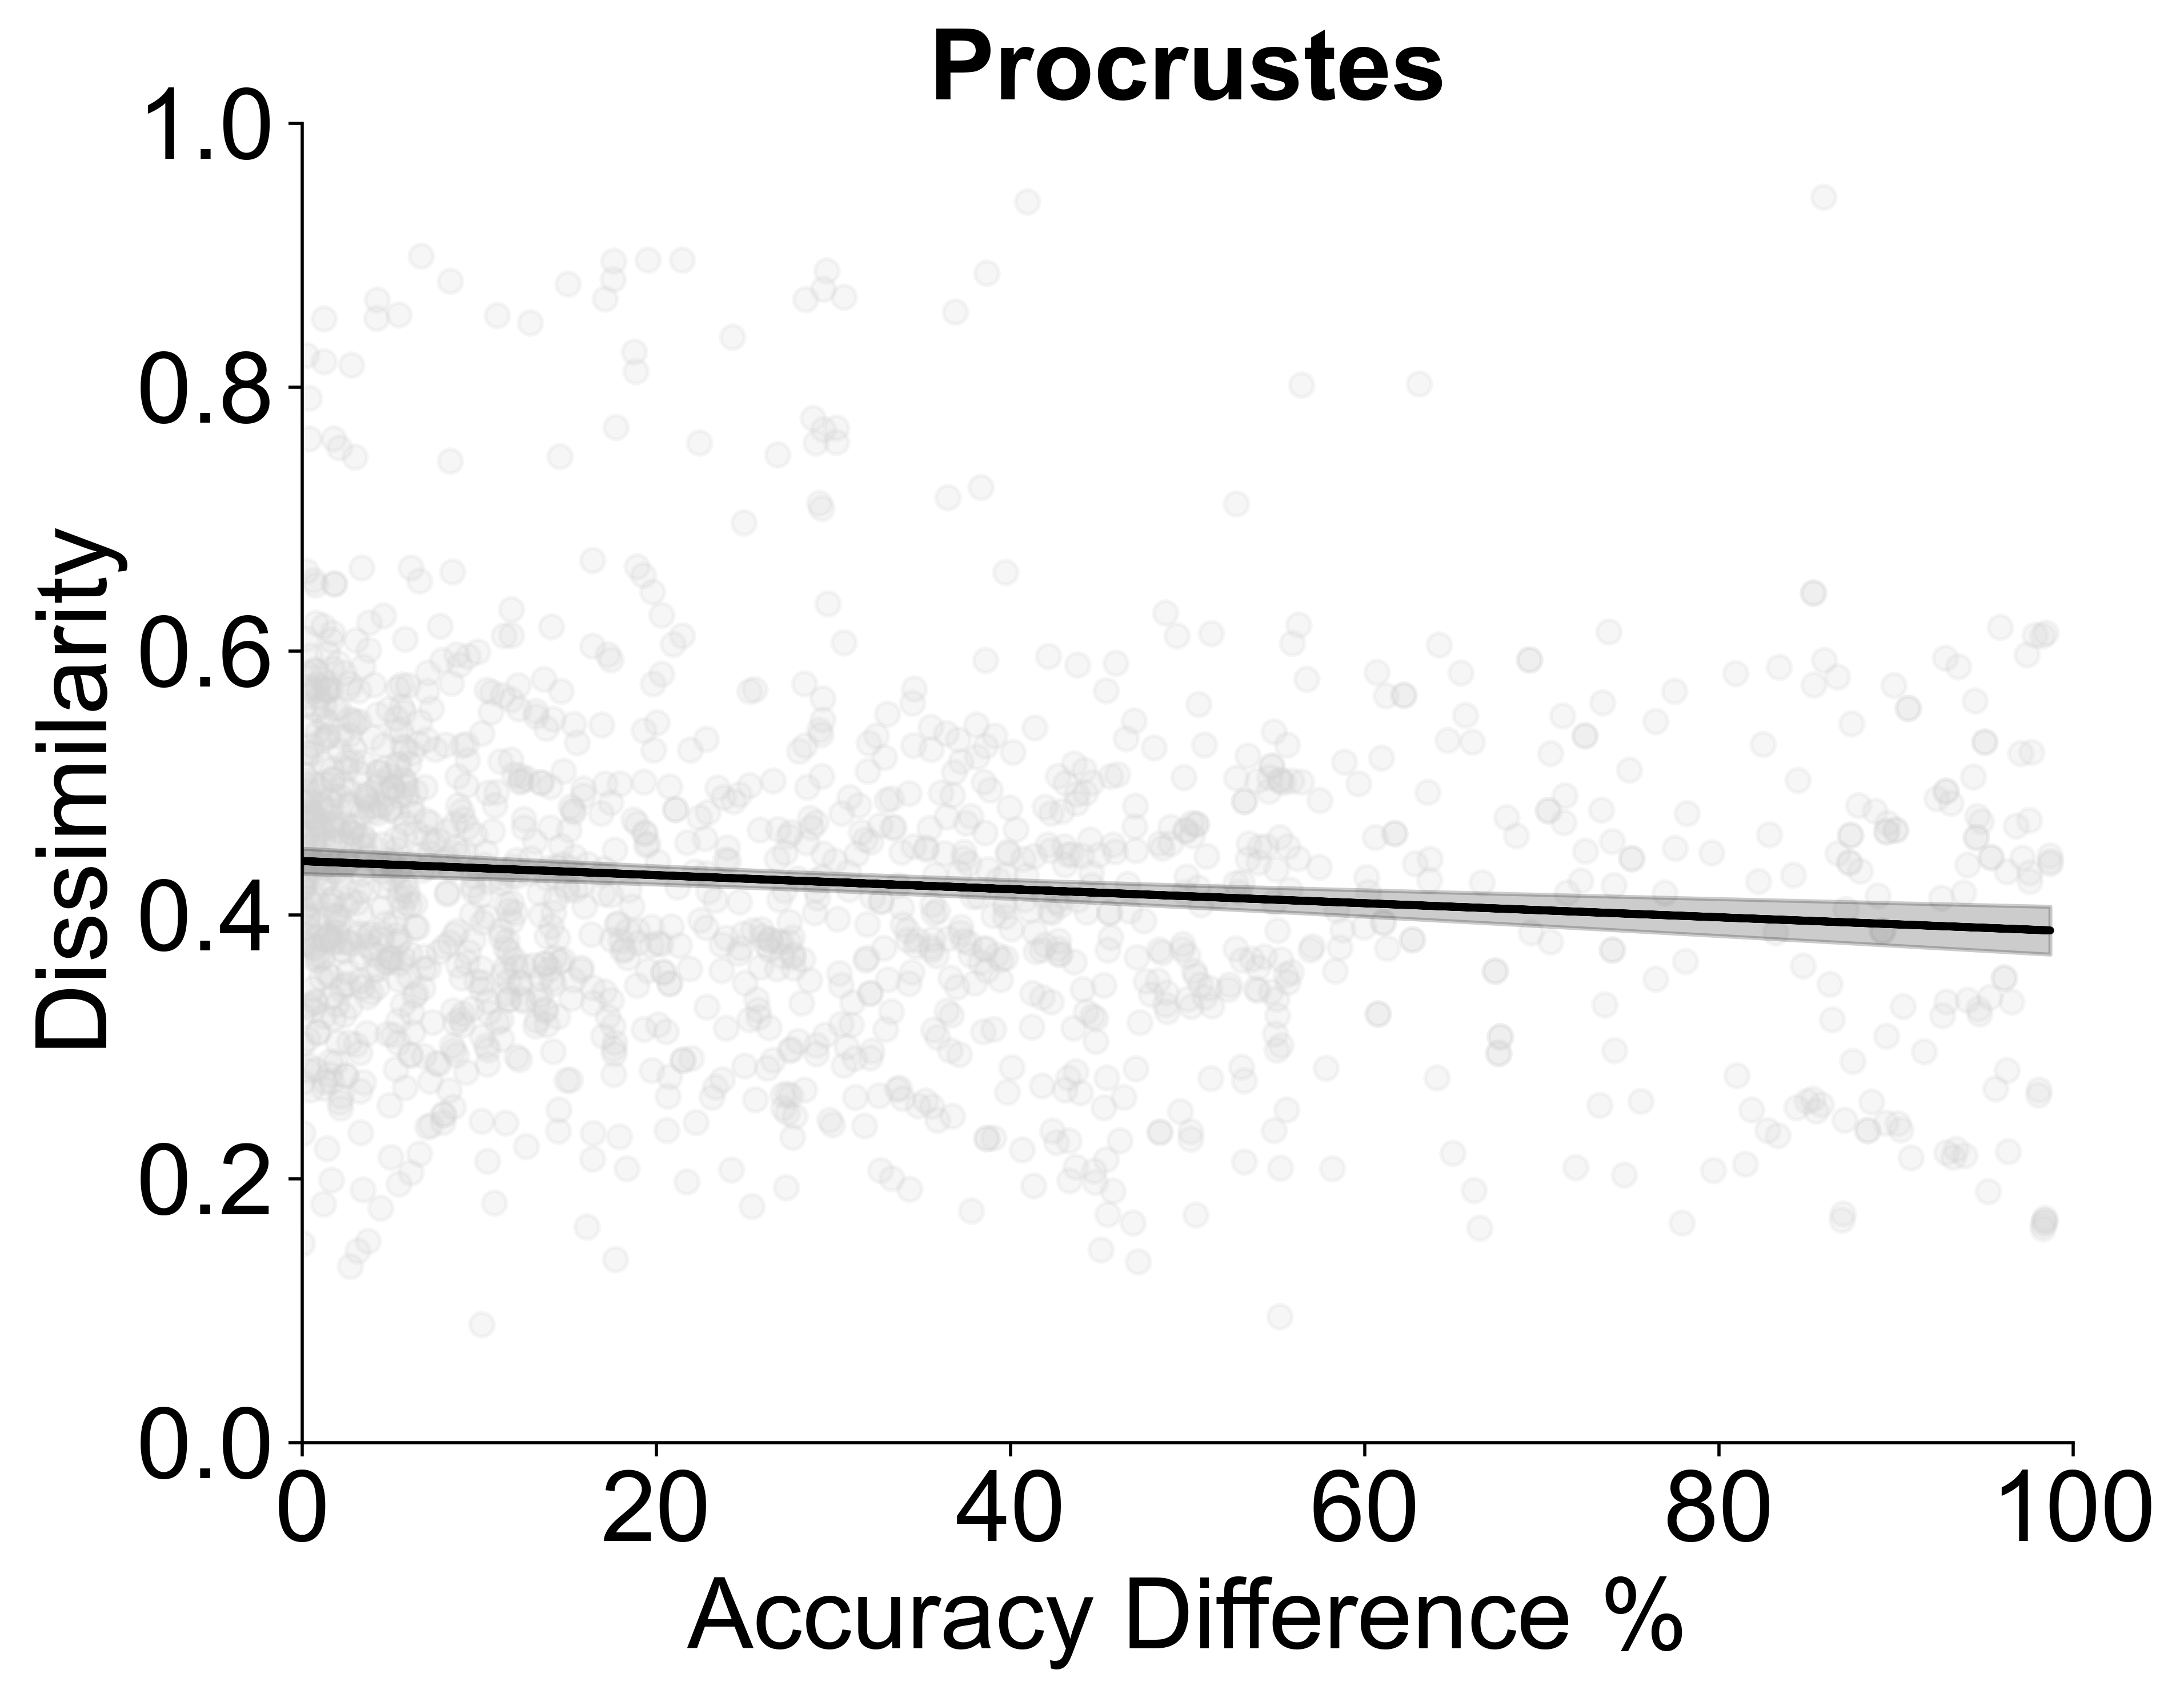

dsa
beta: 0.21600583645292412
intercept: 0.39910594086005535
r squared: 0.13230881473939138
p_value for 0.21600583645292412: 3.2797329369503224e-47


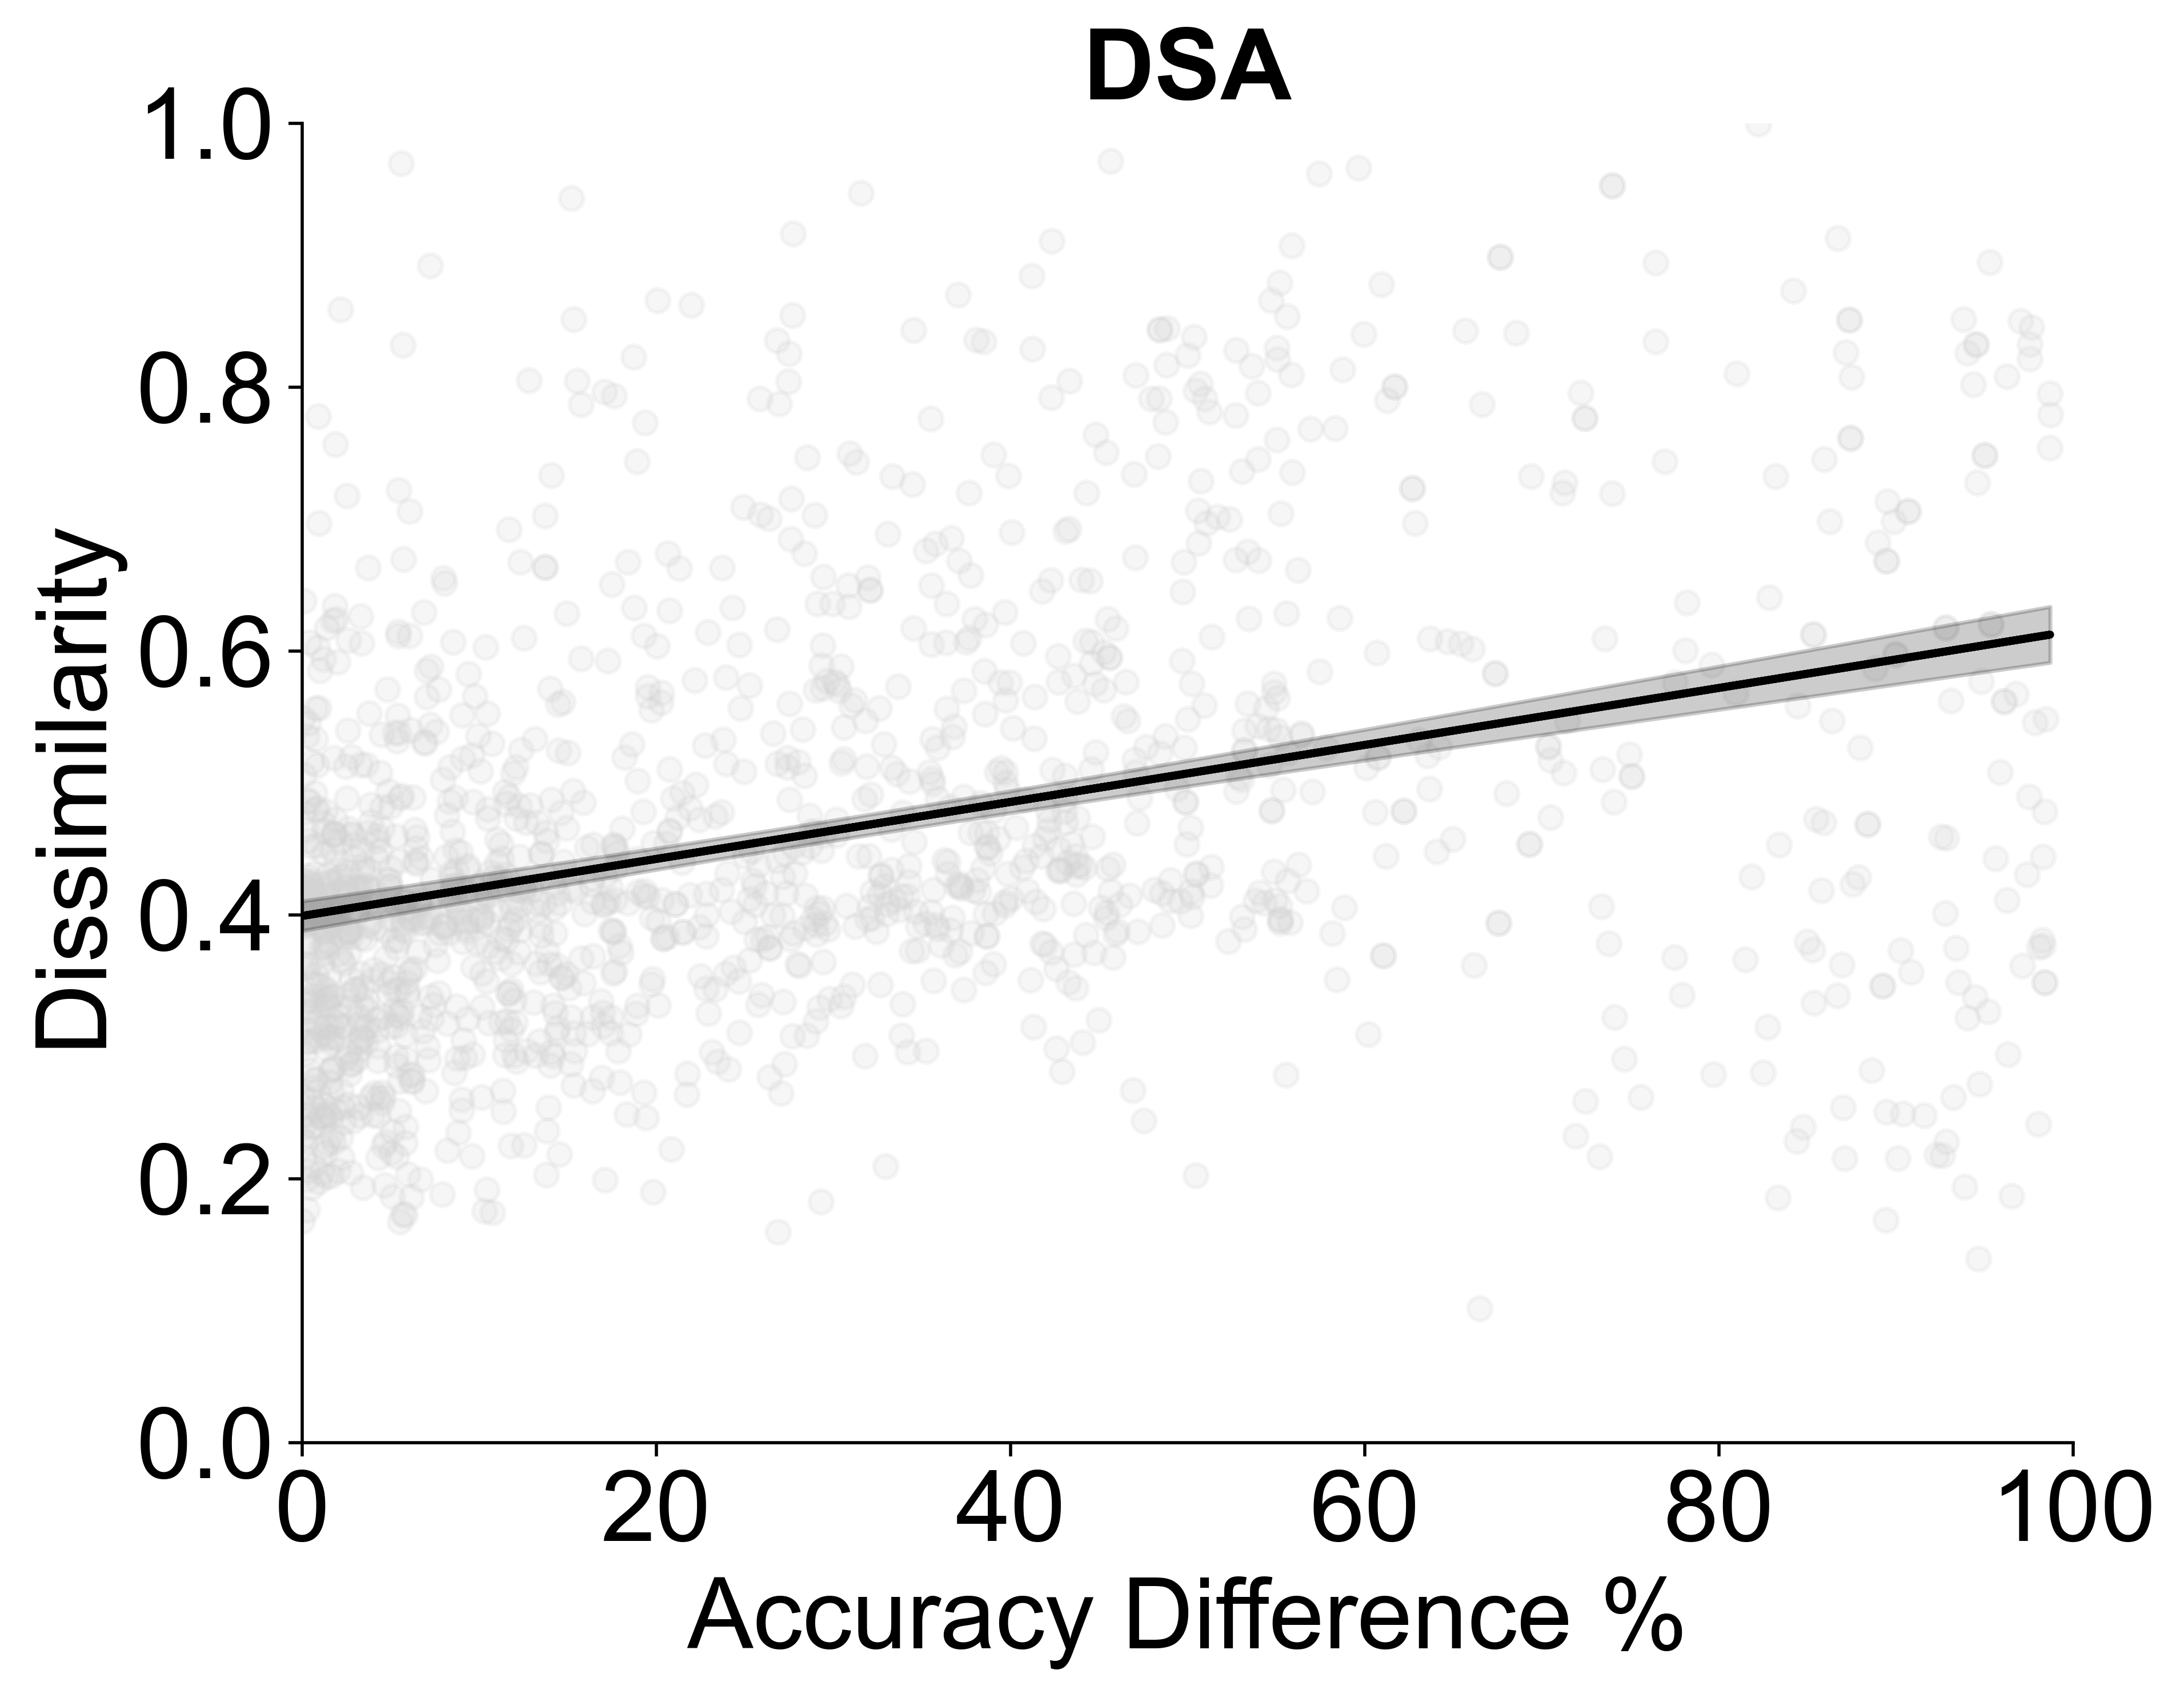

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats  # Importing for t-statistic and p-value calculation

# Assuming dissimilarities_groups, groups_training, and color_mapping_metrics are defined

SIZE_DEFAULT = 25
SIZE_LARGE = 25
plt.rc("font", family="Arial")
plt.rc("font", weight="normal")
plt.rc("font", size=SIZE_DEFAULT)
plt.rc("axes", titlesize=SIZE_LARGE)
plt.rc("axes", labelsize=SIZE_LARGE)
plt.rc("xtick", labelsize=SIZE_DEFAULT)
plt.rc("ytick", labelsize=SIZE_DEFAULT)
# X-axis values
x_values = [i * 20 for i in range(6)]

# Measures for dissimilarities and accuracies
measures_plot1 = ["cka", "procrustes", "dsa"]
measures_plot2 = ["accuracy_1", "accuracy_2"]

# Initialize lists and dictionaries to collect data
abs_diff_accuracies_cumulated = []
dissimilarity_values_cumulated = {measure: [] for measure in measures_plot1}
accuracy_values = {
    measure: [] for measure in measures_plot2
}  # Initialize accuracy_values dictionary

# Calculate dissimilarity values and absolute accuracy differences
for group_training in groups_training:
    if (
        "master_frozen" not in group_training
        and "untrained" not in group_training
        and "master_master" not in group_training
        and "pretrain_partial" not in group_training
    ):
        dissimilarities_interpolated = dissimilarities_groups[group_training]

        # Collect accuracy values to calculate absolute differences
        for key in measures_plot2:
            dict_sampling_to_mean_and_errors = dissimilarities_interpolated[key]
            accuracy_values[key] = [
                value[2] for value in dict_sampling_to_mean_and_errors.values()
            ]
            # Flatten the list
            accuracy_values[key] = [
                item for sublist in accuracy_values[key] for item in sublist
            ]

        # Calculate the absolute difference between the two accuracy measures
        abs_diff_accuracies = np.abs(
            np.array(accuracy_values["accuracy_1"])
            - np.array(accuracy_values["accuracy_2"])
        )
        abs_diff_accuracies_cumulated.extend(abs_diff_accuracies.tolist())

        # Plot the dissimilarities against the absolute accuracy difference
        for idx, key in enumerate(measures_plot1):
            dict_sampling_to_mean_and_errors = dissimilarities_interpolated[key]
            dissimilarity_values = [
                value[2] for value in dict_sampling_to_mean_and_errors.values()
            ]
            # Flatten the list
            dissimilarity_values = [
                item for sublist in dissimilarity_values for item in sublist
            ]
            dissimilarity_values_cumulated[key].extend(dissimilarity_values)

# Create a plot for each measure in measures_plot1
for idx, measure in enumerate(measures_plot1):
    # Ensure X and Y have the same length and remove NaNs
    print(measure)
    X = np.array(abs_diff_accuracies_cumulated)
    Y = np.array(dissimilarity_values_cumulated[measure])

    # Check for NaN values in X or Y and remove them
    valid_indices = ~np.isnan(X) & ~np.isnan(Y)
    X = X[valid_indices].reshape(-1, 1)
    Y = Y[valid_indices]

    # Perform linear regression
    model = LinearRegression()
    model.fit(X, Y)

    # Predict y values for the regression line
    Y_pred = model.predict(X)

    # Get the slope (beta) and intercept
    beta = model.coef_[0]
    intercept = model.intercept_
    print(f"beta: {beta}")
    print(f"intercept: {intercept}")

    # Compute residuals and their variance
    residuals = Y - Y_pred
    residual_variance = np.var(residuals, ddof=2)

    # Compute variance of X
    X_mean = np.mean(X)
    X_variance = np.sum((X - X_mean) ** 2)
    r_squared = model.score(X, Y)
    print(f"r squared: {r_squared}")
    # Standard error of the slope (beta)
    standard_error_beta = np.sqrt(residual_variance / X_variance)

    # Calculate t-statistic and p-value
    t_statistic = beta / standard_error_beta
    df = len(X) - 2  # degrees of freedom
    p_value = 2 * stats.t.sf(np.abs(t_statistic), df)
    print(f"p_value for {beta}: {p_value}")

    # Mis-specification error (MSE)
    mse = np.mean(residuals**2)

    # Confidence interval for the regression line
    X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_pred_range = model.predict(X_range)
    se_line = np.sqrt(
        residual_variance * (1 / len(X) + (X_range - X_mean) ** 2 / X_variance)
    )
    ci_upper = y_pred_range.flatten() + 1.96 * se_line.flatten()
    ci_lower = y_pred_range.flatten() - 1.96 * se_line.flatten()

    # Create the main plot
    fig, ax_main = plt.subplots(figsize=(8, 6), dpi=500)

    # Main plot: scatter plot of observations and the regression line
    ax_main.scatter(X, Y, color="lightgray", label="Observations", alpha=0.2)
    ax_main.plot(
        X,
        Y_pred,
        color="black",
        label=f"{measure} Regression",
        linewidth=2,
    )

    # Plot the confidence interval
    ax_main.fill_between(
        X_range.flatten(),
        ci_lower.flatten(),
        ci_upper.flatten(),
        color="black",
        alpha=0.2,
        label="95% Confidence Interval",
    )

    # Set axis labels and title for the main plot
    ax_main.set_xlabel("Accuracy Difference %")
    ax_main.set_ylabel("Dissimilarity")
    ax_main.set_xlim(0, 1)
    ax_main.set_ylim(0, 1)
    ax_main.set_title(f"{name_measures_plot[measure]}", color="black", fontweight="bold")
    # Customize axis limits and hide the top and right spines
    ax_main.spines["right"].set_visible(False)
    ax_main.spines["top"].set_visible(False)
    ax_main.spines["left"].set_visible(True)
    ax_main.spines["bottom"].set_visible(True)
    ax_main.grid(False)
    ax_main.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax_main.set_xticklabels(["0", "20", "40", "60", "80", "100"])

    # Show the plot
    plt.show()

In [10]:
group_pairs_master = find_group_pairs_master(config, taskset)
diss_cc = get_dissimilarities_shared_task_shared_curriculum(
    group_pairs_master, dissimilarities_groups, x_values
)

cka


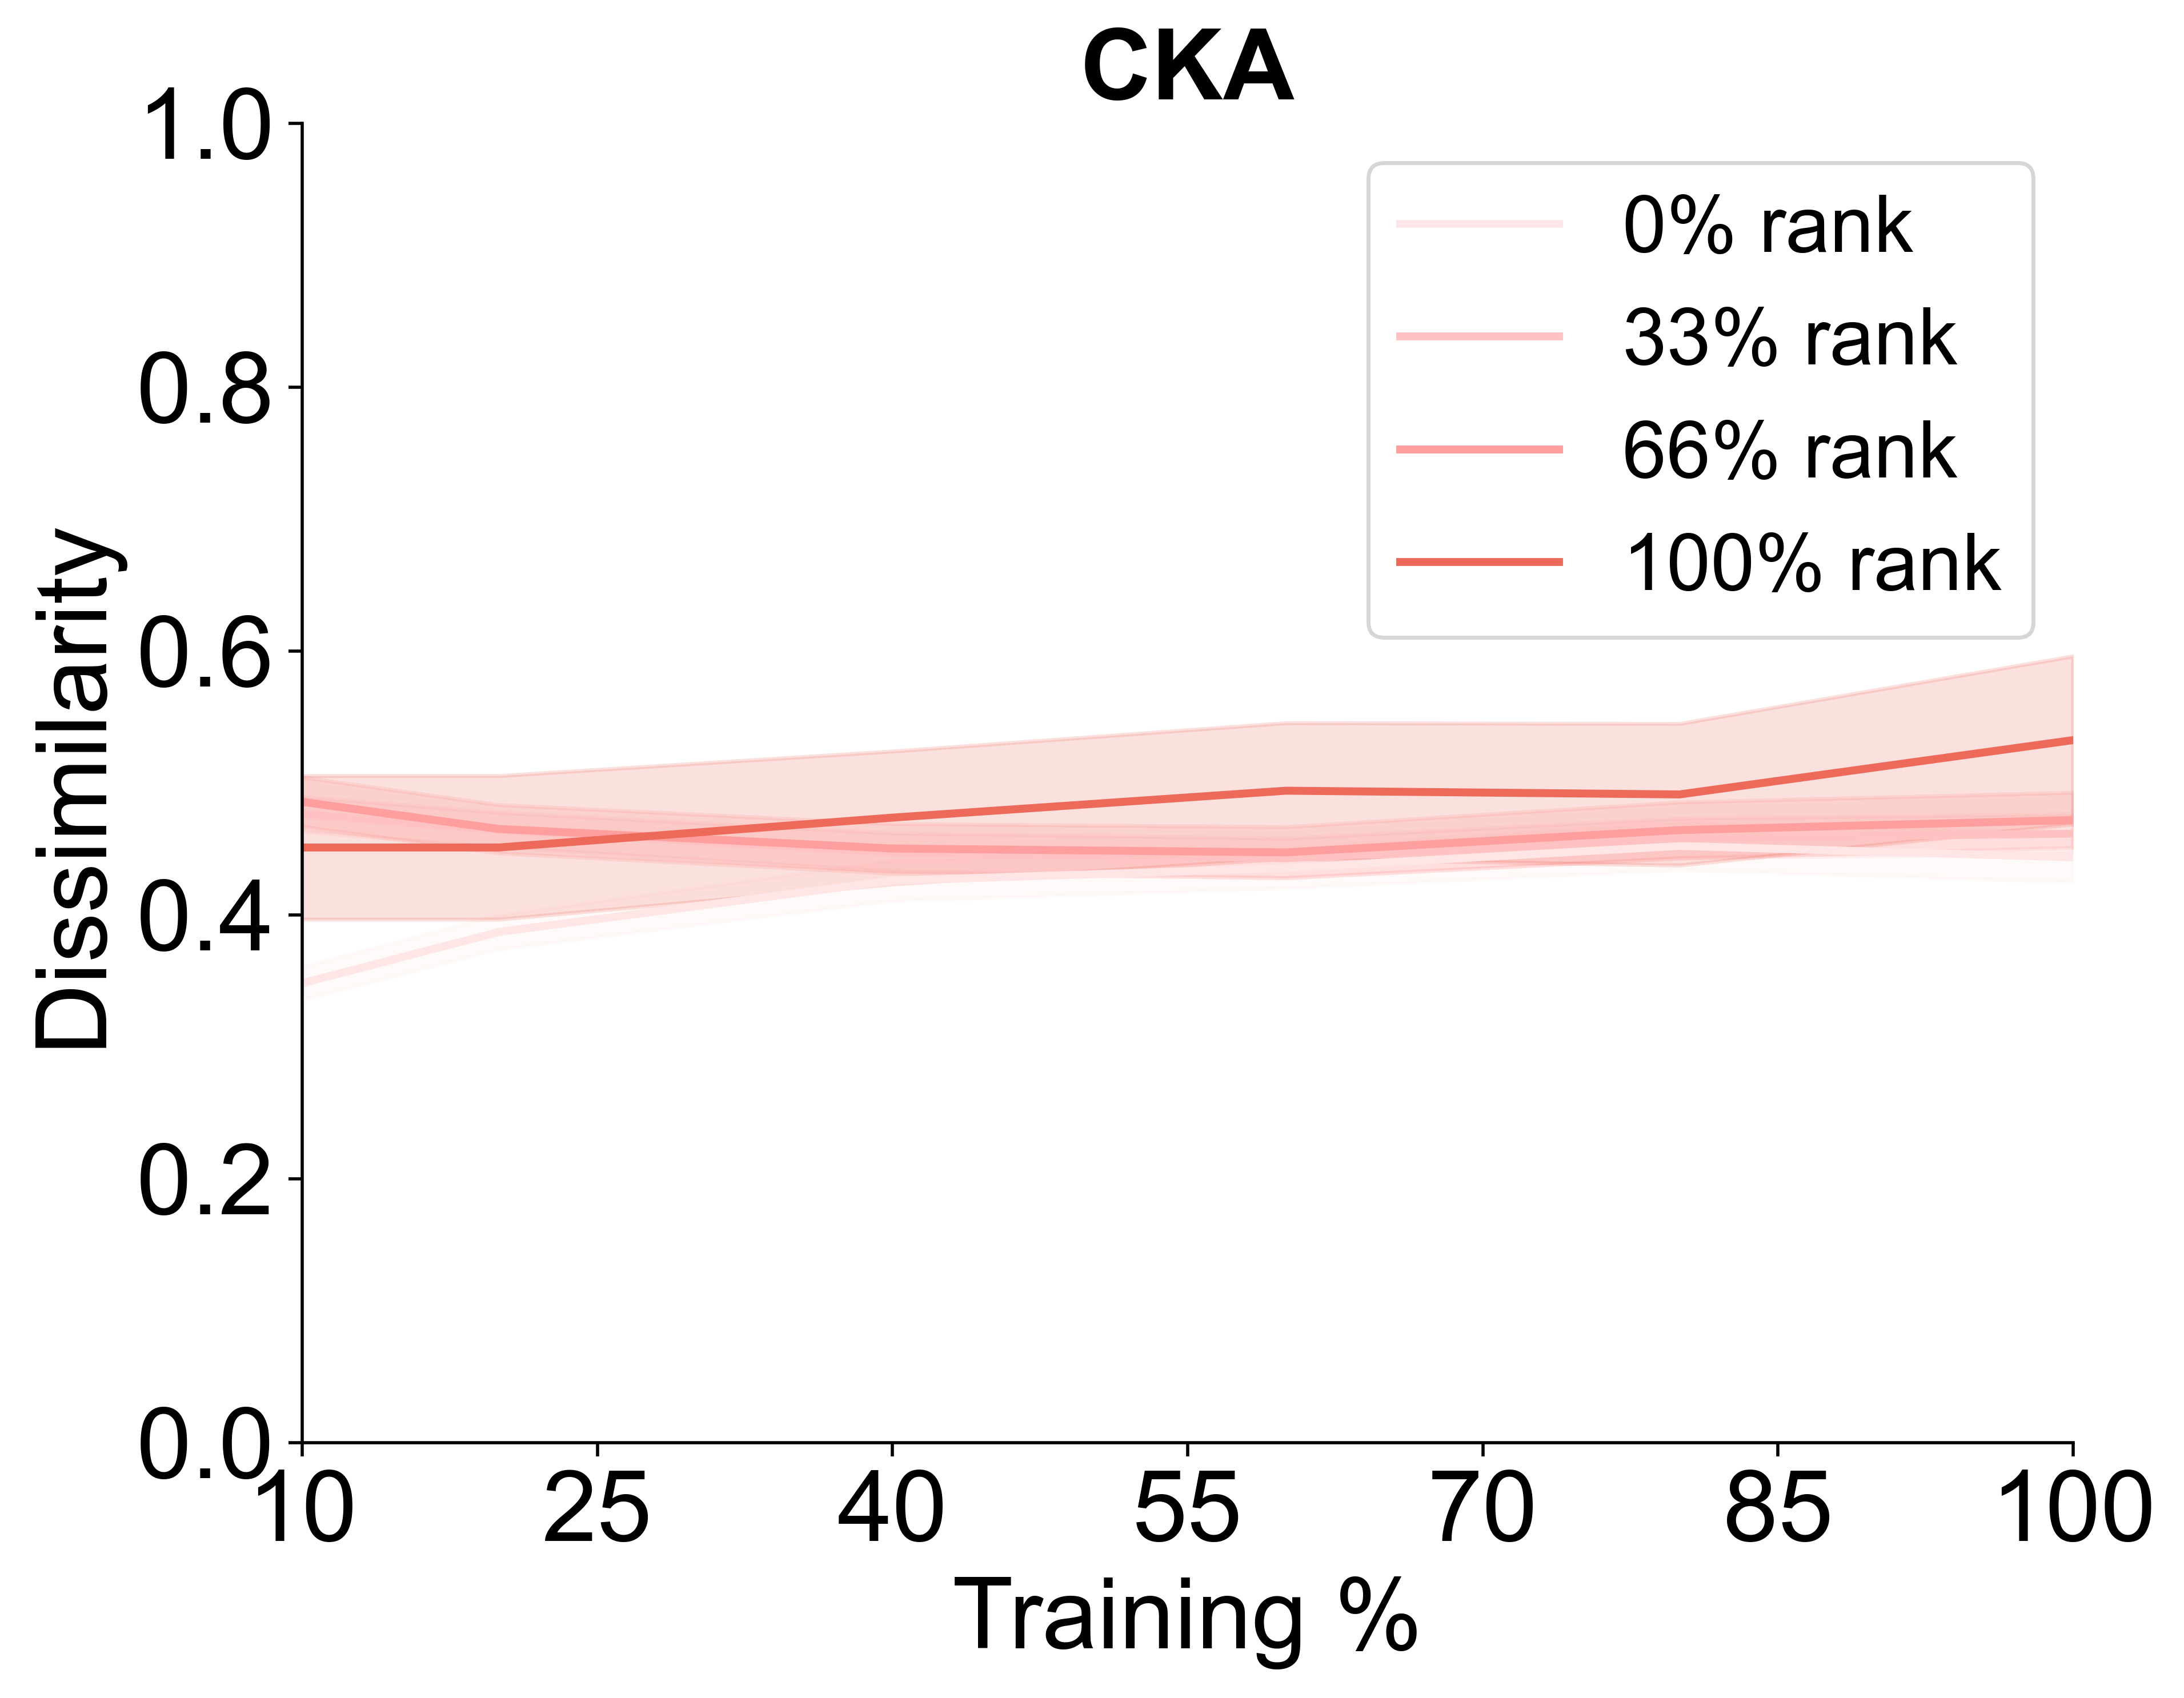

dsa


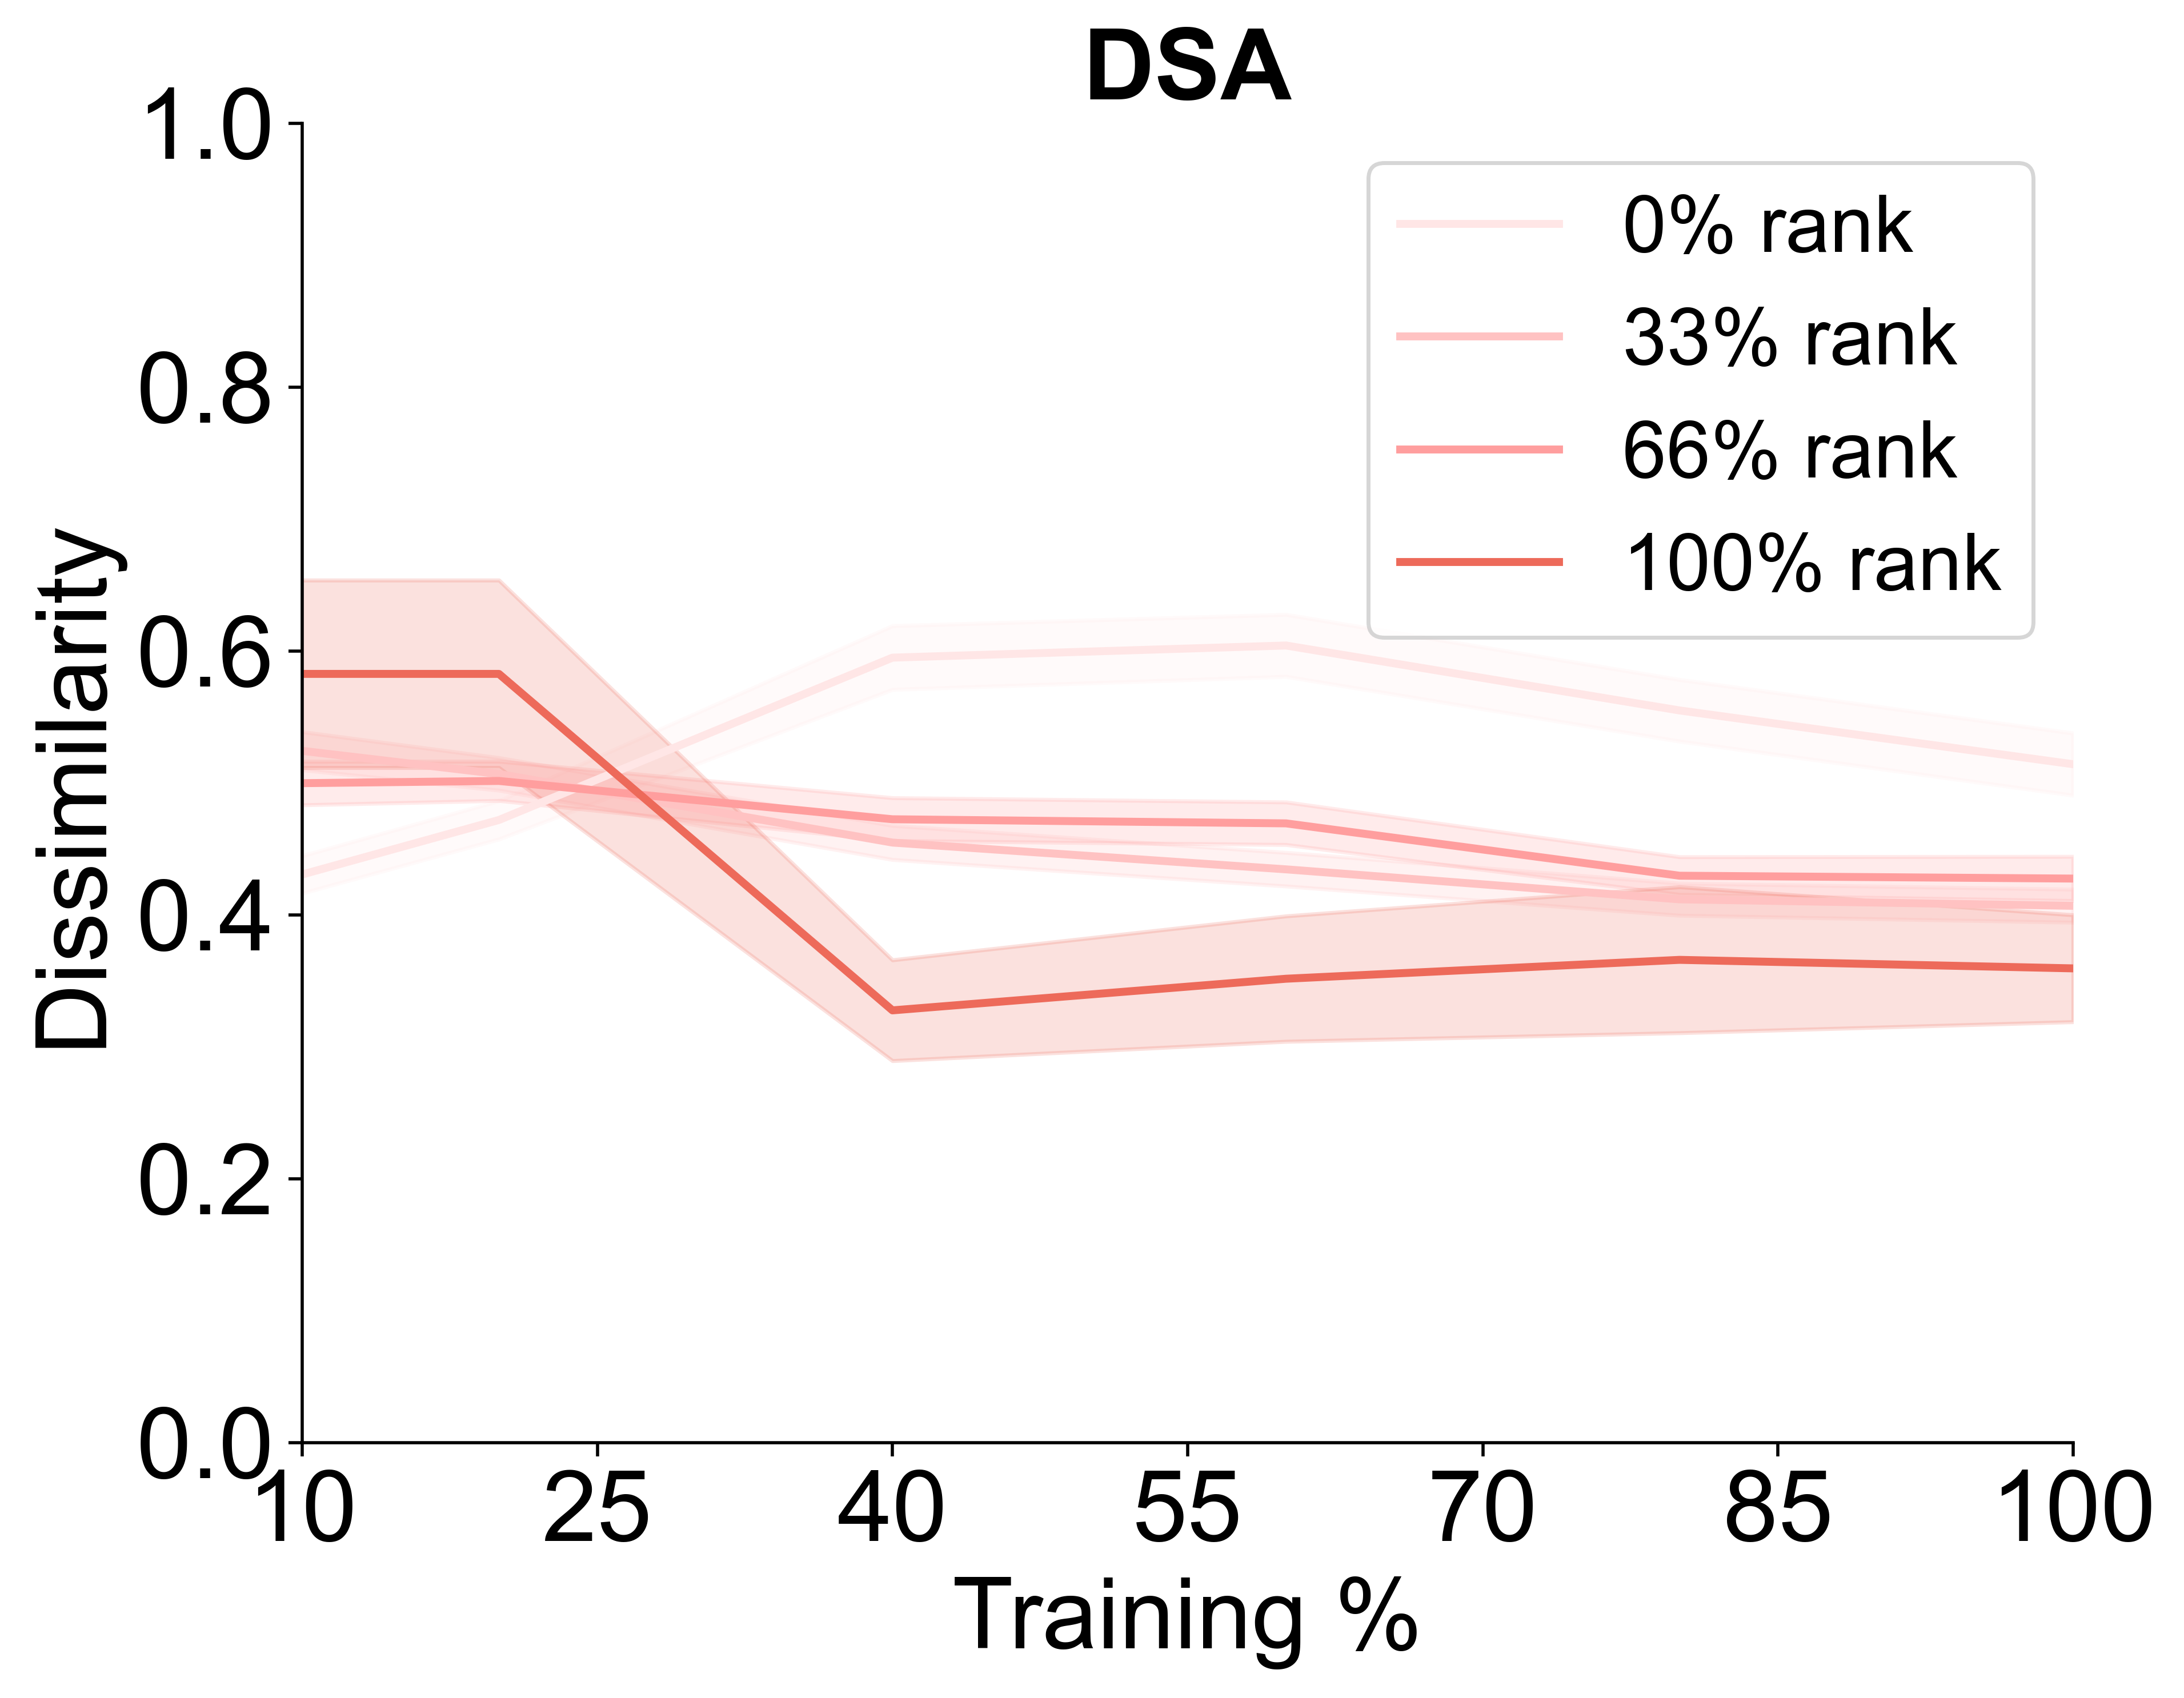

procrustes


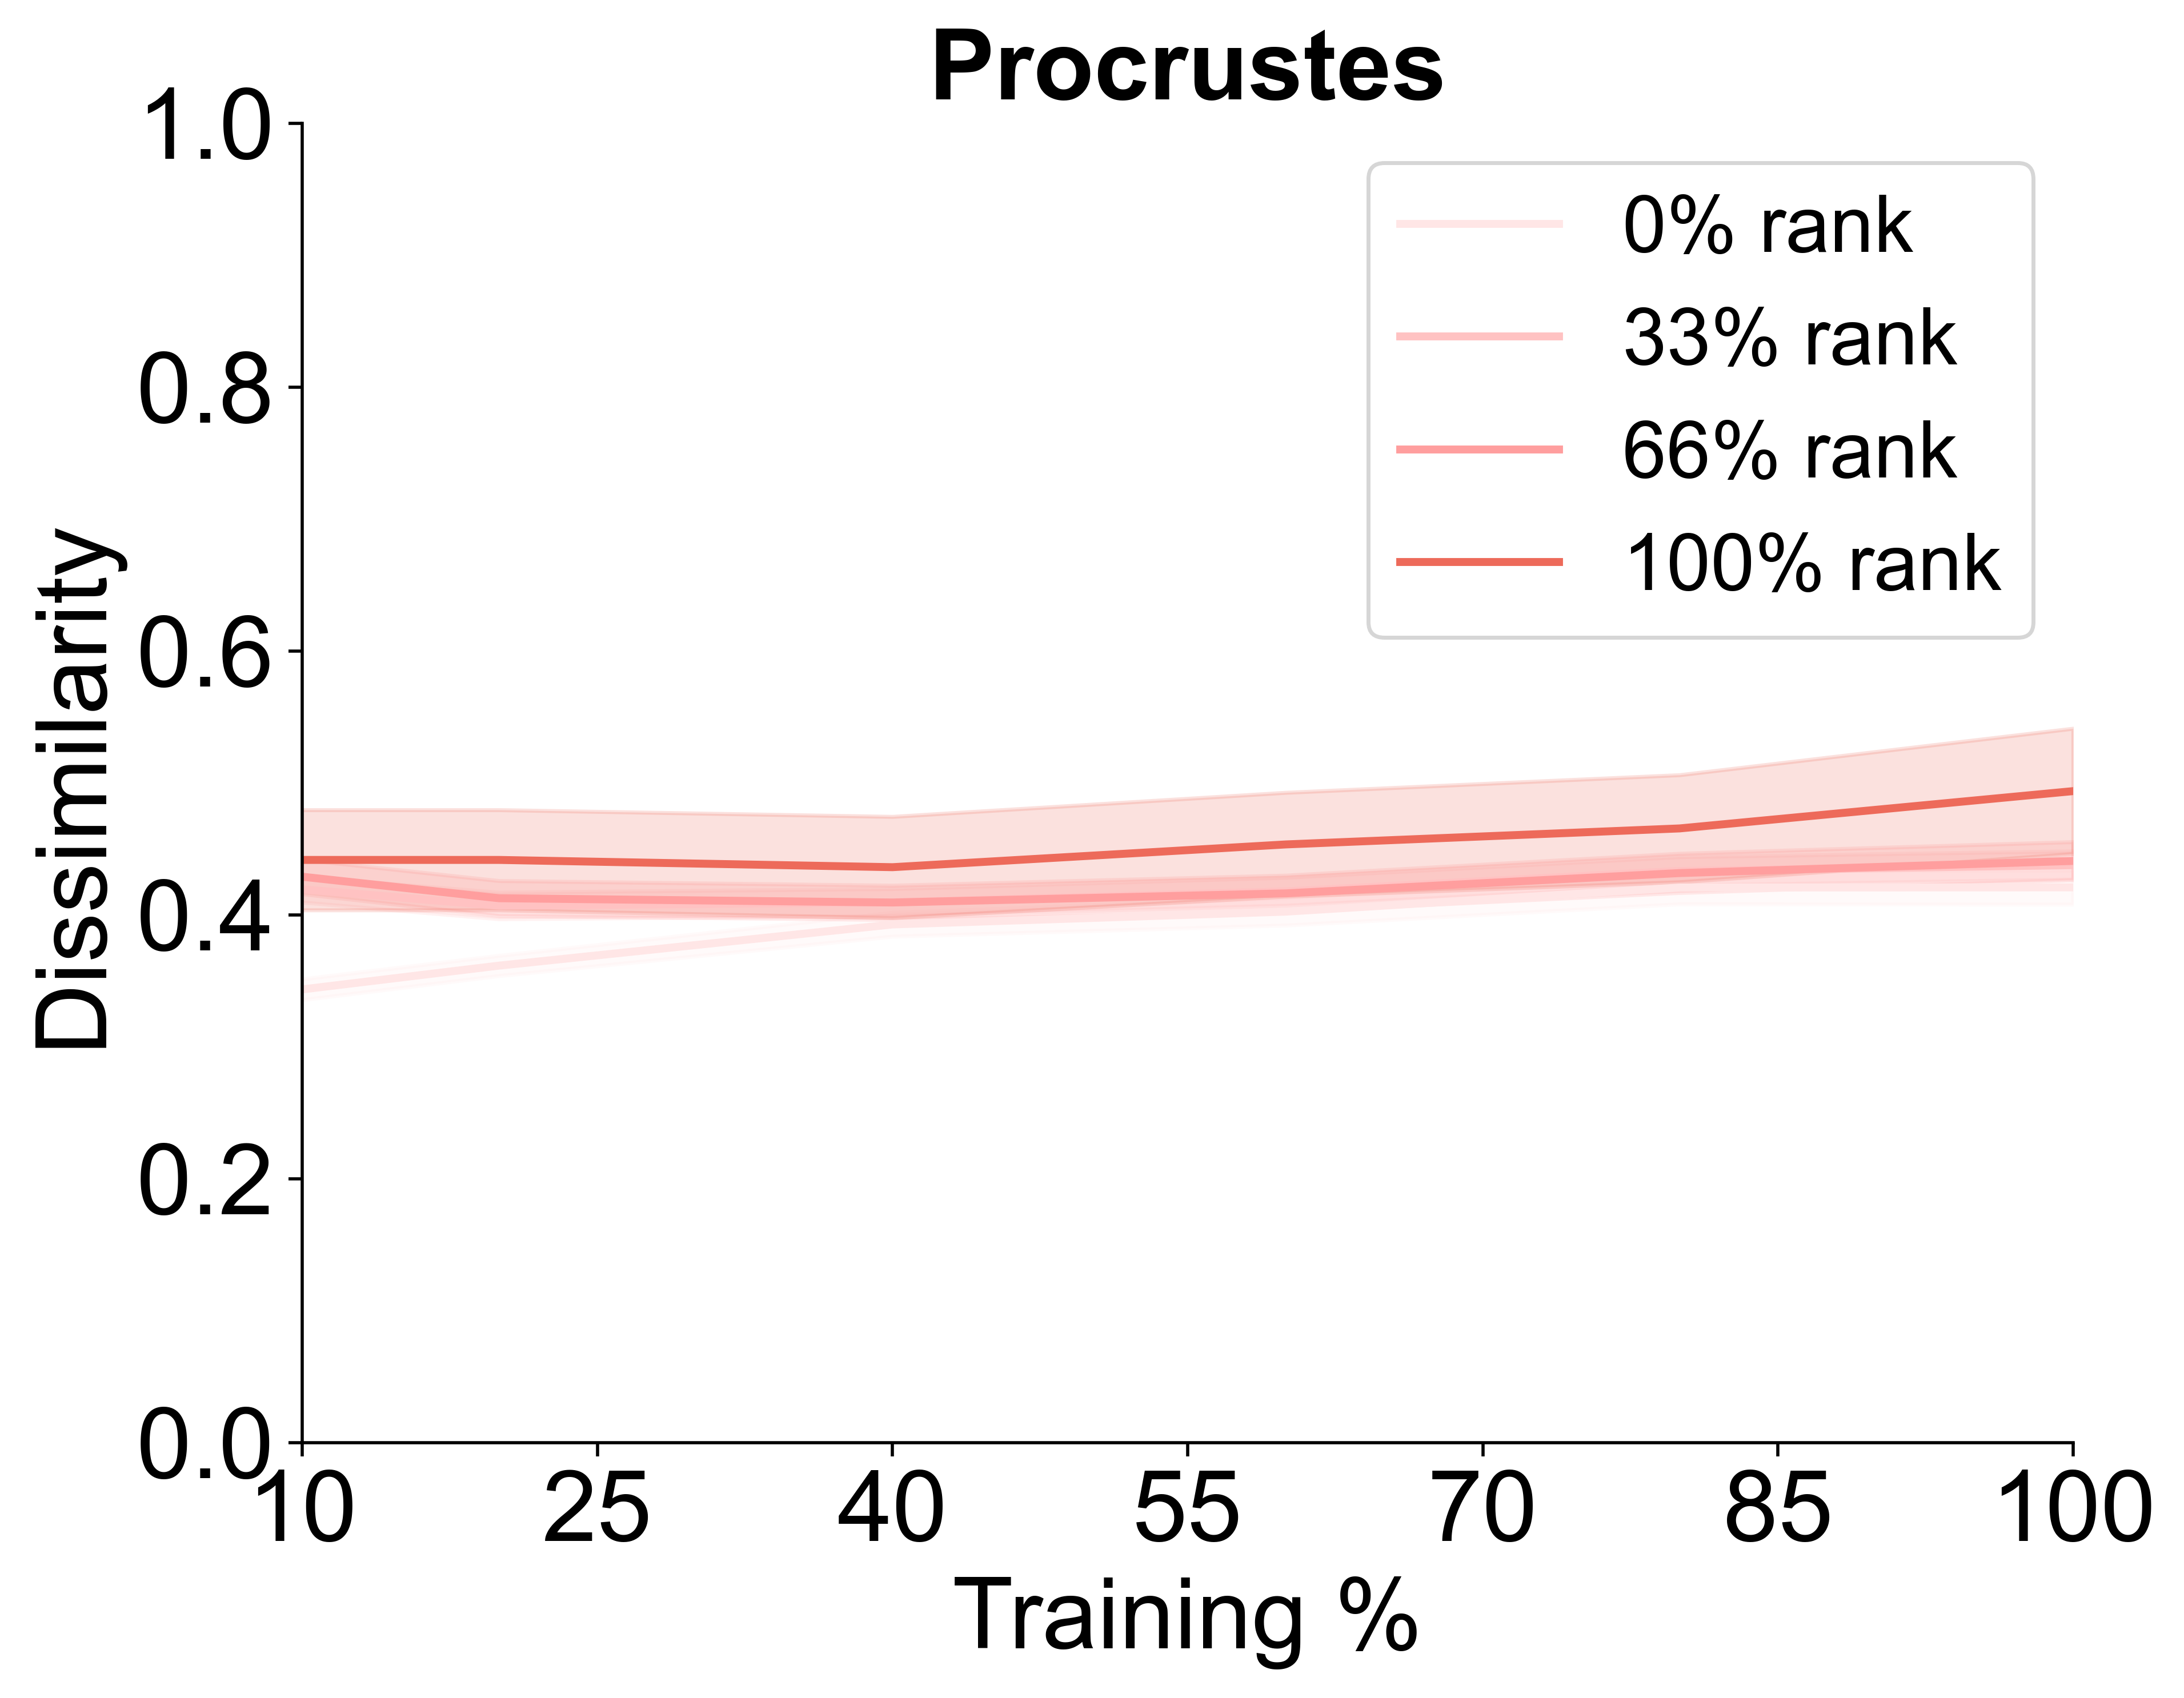

In [18]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Define font sizes and styles for consistency
SIZE_DEFAULT = 25
SIZE_LARGE = 25
plt.rc("font", family="Arial")
plt.rc("font", weight="normal")
plt.rc("font", size=SIZE_DEFAULT)
plt.rc("axes", titlesize=SIZE_LARGE)
plt.rc("axes", labelsize=SIZE_LARGE)
plt.rc("xtick", labelsize=SIZE_DEFAULT)
plt.rc("ytick", labelsize=SIZE_DEFAULT)

# Normalize the number of shared tasks to range between 0 and 1 for color mapping
all_shared_tasks = [shared for measure in diss_cc for shared in diss_cc[measure]]
min_shared = min(all_shared_tasks)
max_shared = max(all_shared_tasks)

# Create a colormap ranging from light to dark red
custom_colors = ["#FFE6E6", "#FFC2C2", "#FF9E9E", "#ED6A5A"]
offset = 0.2

# Plot each measure
for measure in diss_cc:
    print(measure)
    fig, ax = plt.subplots(
        figsize=(8, 6), dpi=500
    )  # Create a new figure for each measure

    # Plot each shared task count
    offsets_dsa = [0, -0.01, 0.03, -0.02]
    offsets_cka = [-0.05, -0.01, 0.04, 0.04]
    shared_order = [0, 33, 66, 100]
    for i, shared in enumerate(sorted(diss_cc[measure].keys())):  # Sort by shared tasks for plotting
        x_new, y_new, y_new_std = diss_cc[measure][shared]
        color = custom_colors[i]
        # Get the color from the colormap
        # Normalize shared task count to get a color, with the offset to avoid very light colors
        norm_shared = offset + (shared - min_shared) / (max_shared - min_shared) * (
            1 - offset
        )

        # Plot with the determined color and label each curve
        ax.plot(
            [5] + x_new[1:], y_new, color=color, linewidth=2, label=f"{int(shared)}% rank"
        )

        # Plot the standard deviation as a shaded region
        ax.fill_between(
            [5] + x_new[1:],
            np.array(y_new) - np.array(y_new_std),
            np.array(y_new) + np.array(y_new_std),
            color=color,
            alpha=0.2,  # Transparency for the shaded area
        )

        # Annotate each curve with its label slightly to the right of the last point
        if measure == "dsa":
            ax.text(
                x_new[-1] * 1.02,  # Adjust x position slightly to the right
                y_new[-1]
                + offsets_dsa[shared_order.index(int(shared))],  # Last y value
                f"",
                color=color,
                horizontalalignment="left",
                verticalalignment="center",
            )
        else:
            ax.text(
                x_new[-1] * 1.02,  # Adjust x position slightly to the right
                y_new[-1]
                + offsets_cka[shared_order.index(int(shared))],  # Last y value
                f"",
                color=color,
                horizontalalignment="left",
                verticalalignment="center",
            )

    # Set axis labels
    ax.set_xlabel("Training %")
    ax.set_ylabel("Dissimilarity")

    # Customize plot limits
    ax.set_ylim(0, 1)  # Adjust this as needed
    ax.set_xlim(10, max(x_new))  # Ensure space on the right side of the plot for labels

    # Hide all but the bottom and left spines (axis lines)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
    ax.set_title(f"{name_measures_plot[measure]}", color="black", fontweight="bold")

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position("left")
    ax.xaxis.set_ticks_position("bottom")
    ax.set_xticks([10, 25, 40, 55, 70, 85, 100])
    ax.set_xticklabels(["10", "25", "40", "55", "70", "85", "100"])

    # Add a legend to the plot
    # Add a legend to the plot
    ax.legend(
        loc="upper right", fontsize=20
    )  # Adjust bbox_to_anchor for position

    # ax.legend(loc="upper right")

    # Set title
    plt.show()